In [337]:
import meshio
import numpy as np
from sympy import symbols, Eq, solve, sqrt
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D 
from ipywidgets import interact

In [338]:
# LOAD MESH: [-0.5,0.5]^2, N 25 
mesh_file_path = "/home/aspadotto/meshes/square.msh"
mesh = meshio.read(mesh_file_path)

# face2node connectivity
faces = mesh.cells[0].data

# node coordinates
coords = mesh.points

# Add dummy column to host faces with more than 3 vertices
faces = np.c_[faces, -1*np.ones(faces.shape[0])]
faces = faces.astype(int)

# Sizes
Nfaces_init = faces.shape[0]
Npoints_init = coords.shape[0]
Nfaces = Nfaces_init
Npoints = Npoints_init

# Mask for elements: 0 if uncut, 1 if cut, 2 if generated by cut
cut_faces = np.zeros(Nfaces)

# central circle radius
rho = 0.25

# gamme_edge2face connectivity (not ordered, created during mesh breaking)
# it is created during mesh breaking

# in/ex mask (0: in, 1: ex, -1: cut cell)
side_mask = -1*np.ones(Nfaces)

# boundary mask, code:
# 0: internal
# 1: x=-0.5
# 2: y=-0.5
# 3: x= 0.5
# 4: y= 0.5
# attention: bnd_mask keeps its size after mesh breaking 
# it is ok as long as intface doesn't touch boundary
bnd_mask = np.zeros(Npoints_init)
for ino in range(Npoints_init):
    if (abs(coords[ino,0]+0.5)<1e-6):
        bnd_mask[ino]= 1  
    if (abs(coords[ino,1]+0.5)<1e-6):
        bnd_mask[ino] = 2
    if (abs(coords[ino,0]-0.5)<1e-6):
        bnd_mask[ino] = 3  
    if (abs(coords[ino,1]-0.5)<1e-6):
        bnd_mask[ino] = 4
            
# ASSUMPTIONS ON MESH
## each node has list of points in counterclock-wise sense
## first 2 points of generated element are on gamma

# other data
sigma_ex = 1
sigma_in = 1

In [157]:
print("Points (initial): ", Npoints, "Coords: ", coords.shape)
print ("Faces (initial): ", Nfaces)

Points (initial):  790 Coords:  (790, 3)
Faces (initial):  1478


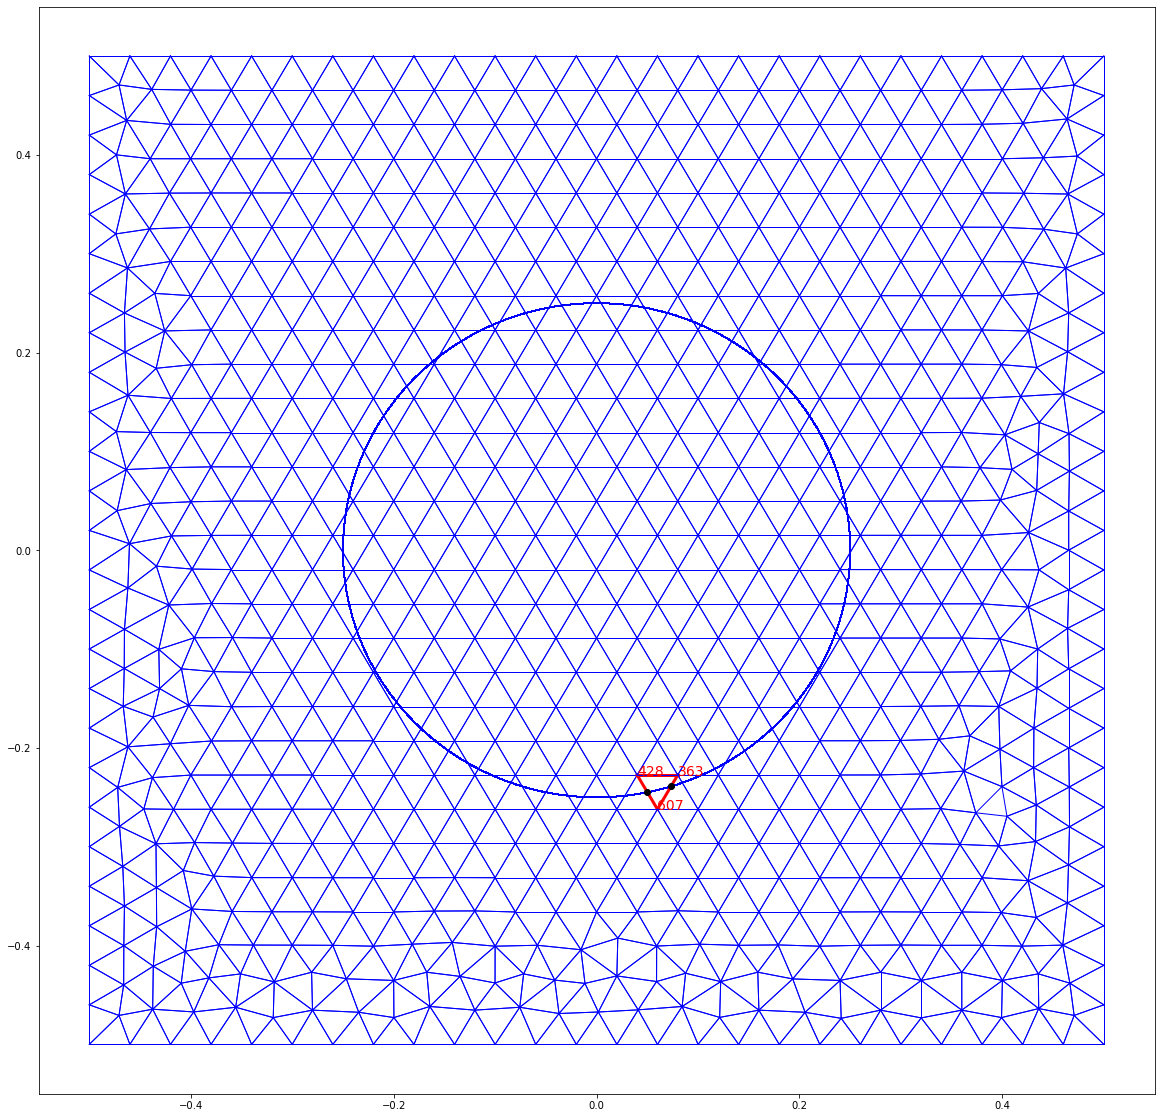

In [8]:
# visualization 

fig, ax = plt.subplots(figsize=(20,20))
for ifa in range(Nfaces-1):
    for ino in range(3):
       p1 = coords[faces[ifa,ino],:]
       p2 = coords[faces[ifa,(ino+1)%3],:]
       dx = p2-p1
       xx = [p1[0],p2[0]]
       yy = [p1[1],p2[1]]
       #ax.arrow(p1[0],p1[1], dx[0],dx[1],head_width=0.005)
       ax.plot(xx,yy,'b', linewidth=1)
       if (ifa==154):
          ax.plot(xx,yy,'r', linewidth=3)
          text_position = p1
          text_content = str(faces[ifa,ino])
          ax.text(p1[0], p1[1], text_content, fontsize=14, color='red')
          [cut, int_coords] = calc_intersection(p1[0], p2[0], p1[1],p2[1])
          if cut:
           #print ("cut! ",int_coords)
           ax.plot(int_coords[0],int_coords[1],'ko', linewidth=4)
       circle = plt.Circle((0, 0), radius=rho, edgecolor='b', facecolor='none')
       ax.add_patch(circle)

In [158]:
def is_proper(value):
    return (value.is_real and abs(value)<=1 and value>0)

def calc_intersection(x1,x2,y1,y2):
    # Define variables
    x, y, t= symbols('x y t')
    # Equation of the circle centered at the origin
    circle_equation = Eq(x**2 + y**2, rho**2)
    # Parametric equations of the line segment
    segment_x = x1 + (x2 - x1) * t
    segment_y = y1 + (y2 - y1) * t
    # Substitute parametric equations into the circle equation
    circle_intersection = circle_equation.subs({x: segment_x, y: segment_y})
    # Solve the resulting quadratic equation for t
    intersection_points = solve(circle_intersection, t)
    #print("Curvilinear abscissa: ", intersection_points)
    if (len(intersection_points)==0):
        return [False, np.array([0.0,0.0,0.0])]
       # Evaluate the parametric equations at the intersection points
    intersection_coordinates = \
       [(segment_x.subs(t, point), segment_y.subs(t, point)) for point in intersection_points]
    #print ("Intersection points: ", intersection_coordinates) 
    if (is_proper(intersection_points[0])):
        #print ("it's the first")
        point = intersection_coordinates[0]
        return [True, np.array([point[0], point[1],0.0])]
    elif (is_proper(intersection_points[1])):
        #print ("it's the second")
        point = intersection_coordinates[1]
        return [True, np.array([point[0], point[1],0.0])]
    else:
        return [False, np.array([0.0,0.0,0.0])]

In [159]:
# check if face is cut
def is_cut(ifa):
    r_min = 1e6
    r_max = 0
    for ino in range(3):
        r = np.linalg.norm(coords[faces[ifa,ino]])
        if (r<=r_min):
            r_min = r
        if (r>=r_max):
            r_max = r
    if (r_min<=rho and rho<=r_max):
        return True
    
# check if point is present
def check_if_present(node_coords):
   for ino in range(Npoints):
        diff = node_coords-coords[ino]
        if (np.dot(diff,diff)<1e-10):
            print ("Point already there")
            return [True, ino]
   return [False, -1] 

In [160]:
def split_face(ifa):
    global Npoints
    global coords
    inters_mask = [0,0,0] #Pattern of intersections to get orientation (if counter_clock)
    vert_mask   = [0,0,0] #Pattern of vertices for orientation (increase if side is cut)
    inters_found = 0      
    int1 = -1             #idx intersection
    int2 = -1 
    # Loop over Edges to find intersection
    for ie in range(3):
        ino1 = faces[ifa,ie]
        ino2 = faces[ifa, (ie+1)%3]
        point1 = coords[ino1,:]
        point2 = coords[ino2,:]
        [cut, int_coords] = calc_intersection(point1[0], point2[0], point1[1],point2[1])
        int_coords = int_coords.astype(float)
        if cut:
            # Add point if not already there
            [present, idx] = check_if_present (int_coords)
            if(not present):
                Npoints = Npoints + 1
                coords = np.vstack([coords,np.array([int_coords[0], int_coords[1], 0.0])])
                idx = Npoints-1
            # Mark index
            if (inters_found == 0):
                int1 = idx
                inters_found = inters_found + 1
            else:
                int2 = idx
            # Update Vert mask
            vert_mask [ie] = vert_mask[ie] + 1
            vert_mask [(ie+1)%3] = vert_mask [(ie+1)%3] + 1
            # Update inters_mask
            inters_mask[ie] = 1
    # Get index of vertices in the right order
    vert_mask = np.array(vert_mask)
    loc_v1 = np.where(vert_mask == 2)[0][0]
    print ("vertex mask: ", vert_mask)
    print ("inters_mask: ", inters_mask)
    print("pos of v1: ",loc_v1)
    v1 = faces[ifa,loc_v1]
    v2 = faces[ifa,(loc_v1+1)%3]
    v3 = faces[ifa,(loc_v1+2)%3]
    # Put intersection in right order
    if (inters_mask==[1,1,0] or inters_mask==[0,1,1]):
        int_prec = int1
        int_fol  = int2
    else:
        int_prec = int2
        int_fol  = int1
    # Define list of ordered vertices of new elements (the triangle first)
    # Notice that cut edge is the first
    l1 = [int_fol,int_prec,v1,-1]
    l2 = [int_prec,int_fol,v2,v3]
    return [l1,l2]
    
            

In [340]:
def barycenter (ifa):
    node_per_face = np.count_nonzero(faces[ifa,:] != -1)
    x_T = np.zeros(3)
    for ino in range(node_per_face):
        x_T = x_T + coords[faces[ifa,ino],:]
    return x_T/node_per_face

def calc_surface(ifa):
    #shoelace formula
    mod_F = 0
    node_per_face = np.count_nonzero(faces[ifa,:] != -1)
    for ino in range(node_per_face):
        x1 = coords[faces[ifa,ino],0]
        y1 = coords[faces[ifa,ino],1]
        x2 = coords[faces[ifa,(ino+1)%node_per_face],0]
        y2 = coords[faces[ifa,(ino+1)%node_per_face],1]
        mod_F = mod_F + x1*y2 - x2*y1
    mod_F = 0.5*mod_F
    return mod_F
        
def simpson (a, b, fun, with_s = False, sign = 'plus'):
    # a, b: points in 2D space (np arrays)
    # fun: real function with double argument
    mid1 = a + (b-a)/4
    mid2 = a + (b-a)*2/4
    mid3 = a + (b-a)*3/4
    if   (with_s and sign =='minus'):
        return  np.linalg.norm(b-a)/90*(7*fun(a[0], a[1]) + 
                                        24*fun(mid1[0],mid1[1]) +
                                        6*fun(mid2[0],mid2[1]) + 
                                        8*fun(mid3[0],mid3[1]))
    elif (with_s and sign =='plus'):
        return  np.linalg.norm(b-a)/90*(8*fun(mid1[0],mid1[1]) +
                                        6*fun(mid2[0],mid2[1]) + 
                                       24*fun(mid3[0],mid3[1]) + 
                                        7*fun(b[0], b[1]))
    else: 
        return  np.linalg.norm(b-a)/90*(7*fun(a[0], a[1]) + 
                                        32*fun(mid1[0],mid1[1]) +
                                        12*fun(mid2[0],mid2[1]) + 
                                        32*fun(mid3[0],mid3[1]) + 
                                        7*fun(b[0], b[1]))

In [341]:
# MESH BREAKING
for ifa in range(Nfaces_init):
    #Check if face is cut by circle
    if (is_cut(ifa)):
        print ("Face: ", ifa)
        # Mask the Face
        cut_faces[ifa] = 1
        # Create new nodes and faces
        [f1,f2] = split_face(ifa)
        print (f1,f2)
        # Update list of faces and mask
        faces = np.vstack([faces,np.array(f1)])
        faces = np.vstack([faces, np.array(f2)])
        cut_faces=np.append(cut_faces,2)
        cut_faces=np.append(cut_faces,2)
        Nfaces = Nfaces + 2
        # Update side_mask
        side_mask=np.append(side_mask,-1)
        side_mask=np.append(side_mask,-1)
        if (np.linalg.norm(barycenter(Nfaces-2))<rho):
            side_mask[Nfaces-2] = 0
        else:
            side_mask[Nfaces-2] = 1
        if (np.linalg.norm(barycenter(Nfaces-1))<rho):
            side_mask[Nfaces-1] = 0
        else:
            side_mask[Nfaces-1] = 1       
        # Update gamma_edge (first is internal)
        if ("gamma_edges" in globals()):
            if (side_mask[Nfaces-2]==0):
                gamma_edges = np.vstack([gamma_edges, np.array([Nfaces-2, Nfaces-1])])
            else:
                gamma_edges = np.vstack([gamma_edges, np.array([Nfaces-1, Nfaces-2])])
        else:
            if (side_mask[Nfaces-2]==0):
                gamma_edges = np.array([Nfaces-2, Nfaces-1])
            else:
                gamma_edges = np.array([Nfaces-1, Nfaces-2])
    elif (np.linalg.norm(barycenter(ifa))<rho):
        side_mask[ifa] = 0
    else:
        side_mask[ifa] = 1
        
        

Face:  128
vertex mask:  [2 1 1]
inters_mask:  [1, 0, 1]
pos of v1:  0
[790, 791, 363, -1] [791, 790, 607, 368]
Face:  133
vertex mask:  [1 2 1]
inters_mask:  [1, 1, 0]
pos of v1:  1
[793, 792, 508, -1] [792, 793, 185, 155]
Face:  134
Point already there
vertex mask:  [2 1 1]
inters_mask:  [1, 0, 1]
pos of v1:  0
[793, 794, 185, -1] [794, 793, 508, 480]
Face:  136
vertex mask:  [1 2 1]
inters_mask:  [1, 1, 0]
pos of v1:  1
[796, 795, 672, -1] [795, 796, 428, 506]
Face:  148
Point already there
vertex mask:  [2 1 1]
inters_mask:  [1, 0, 1]
pos of v1:  0
[796, 797, 428, -1] [797, 796, 672, 607]
Face:  151
Point already there
vertex mask:  [2 1 1]
inters_mask:  [1, 0, 1]
pos of v1:  0
[798, 794, 480, -1] [794, 798, 521, 185]
Face:  154
Point already there
Point already there
vertex mask:  [1 2 1]
inters_mask:  [1, 1, 0]
pos of v1:  1
[790, 797, 607, -1] [797, 790, 363, 428]
Face:  158
Point already there
vertex mask:  [1 1 2]
inters_mask:  [0, 1, 1]
pos of v1:  2
[799, 792, 155, -1] [792,

Point already there
Point already there
vertex mask:  [1 1 2]
inters_mask:  [0, 1, 1]
pos of v1:  2
[851, 827, 200, -1] [827, 851, 203, 635]
Face:  1039
Point already there
vertex mask:  [1 1 2]
inters_mask:  [0, 1, 1]
pos of v1:  2
[862, 843, 206, -1] [843, 862, 205, 207]
Face:  1075
Point already there
vertex mask:  [2 1 1]
inters_mask:  [1, 0, 1]
pos of v1:  0
[862, 863, 205, -1] [863, 862, 206, 201]
Face:  1078
Point already there
Point already there
vertex mask:  [1 1 2]
inters_mask:  [0, 1, 1]
pos of v1:  2
[834, 840, 188, -1] [840, 834, 190, 574]
Face:  1079
Point already there
Point already there
vertex mask:  [1 1 2]
inters_mask:  [0, 1, 1]
pos of v1:  2
[859, 863, 201, -1] [863, 859, 204, 205]
Face:  1109
Point already there
vertex mask:  [2 1 1]
inters_mask:  [1, 0, 1]
pos of v1:  0
[864, 821, 282, -1] [821, 864, 669, 444]
Face:  1112
Point already there
Point already there
vertex mask:  [1 1 2]
inters_mask:  [0, 1, 1]
pos of v1:  2
[835, 795, 506, -1] [795, 835, 285, 672]
F

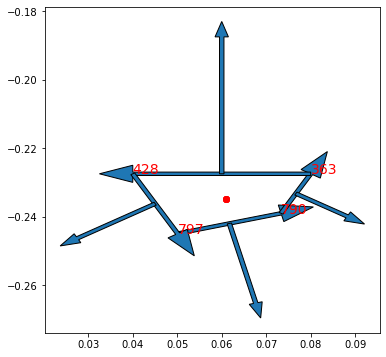

In [9]:
# visualization 
fig, ax = plt.subplots(figsize=(6,6))
ifa = 1491
node_per_face = np.count_nonzero(faces[ifa,:] != -1)
for ino in range(node_per_face):
    p1 = coords[faces[ifa,ino],:]
    p2 = coords[faces[ifa,(ino+1)%node_per_face],:]
    dx = p2-p1
    xx = [p1[0],p2[0]]
    yy = [p1[1],p2[1]]
    ax.arrow(p1[0],p1[1], dx[0],dx[1],head_width=0.005)
    #ax.plot(xx,yy,'b', linewidth=1)
    #ax.plot(xx,yy,'r', linewidth=3)
    text_position = p1
    text_content = str(faces[ifa,ino])
    ax.text(p1[0], p1[1], text_content, fontsize=14, color='red')
    tangent = (p2-p1)[0:2]
    normal = np.array([[0,1],[-1,0]])@tangent
    norm = normal/np.linalg.norm(normal)
    midpoint = p1+0.5*dx
    ax.arrow(midpoint[0],midpoint[1],normal[0],normal[1])
    p = barycenter(ifa)
    ax.scatter(p[0],p[1],color='red')

In [346]:
# check total surf

tot_surf = 0.0
for ifa in range(Nfaces):
    if (cut_faces[ifa]!=1):
        tot_surf = tot_surf+calc_surface(ifa)
    
print ("total surface: ", tot_surf)

total surface:  1.0000000000000004


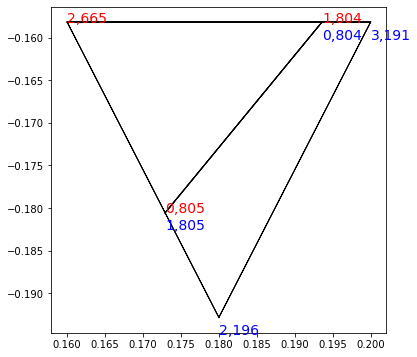

In [303]:
# visualization 
fig, ax = plt.subplots(figsize=(6,6))
ifa_in = gamma_edges[10,0]
ifa_ex = gamma_edges[10,1]

node_per_face_in = np.count_nonzero(faces[ifa_in,:] != -1)
for ino in range(node_per_face_in):
    p1 = coords[faces[ifa_in,ino],:]
    p2 = coords[faces[ifa_in,(ino+1)%node_per_face_in],:]
    dx = p2-p1
    xx = [p1[0],p2[0]]
    yy = [p1[1],p2[1]]
    ax.arrow(p1[0],p1[1], dx[0],dx[1], width = 0.0000005, head_width=0.00005)
    #ax.plot(xx,yy,'b', linewidth=1)
    #ax.plot(xx,yy,'r', linewidth=3)
    text_position = p1
    text_content = str(ino)+","+str(faces[ifa_in,ino])
    ax.text(p1[0], p1[1], text_content, fontsize=14, color='red')
    
node_per_face_ex = np.count_nonzero(faces[ifa_ex,:] != -1)
for ino in range(node_per_face_ex):
    p1 = coords[faces[ifa_ex,ino],:]
    p2 = coords[faces[ifa_ex,(ino+1)%node_per_face_ex],:]
    dx = p2-p1
    xx = [p1[0],p2[0]]
    yy = [p1[1],p2[1]]
    ax.arrow(p1[0],p1[1], dx[0],dx[1], width = 0.0000005, head_width=0.00005)
    #ax.plot(xx,yy,'b', linewidth=1)
    #ax.plot(xx,yy,'r', linewidth=3)
    text_position = p1-1
    text_content = str(ino)+","+str(faces[ifa_ex,ino])
    ax.text(p1[0], p1[1]-0.002, text_content, fontsize=14, color='blue', )

In [51]:
side_mask[np.where(cut_faces==2)[0]]

array([0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
       1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.])

In [55]:
cut_faces[128-2:128+2]

array([0., 0., 1., 0.])

In [24]:
np.where(side_mask==0)[0]

array([ 140,  145,  159,  160,  161,  163,  168,  169,  170,  173,  174,
        175,  176,  178,  180,  183,  185,  193,  197,  198,  199,  208,
        211,  218,  219,  221,  223,  227,  229,  248,  249,  254,  255,
        257,  266,  268,  269,  275,  279,  285,  286,  295,  299,  307,
        316,  317,  318,  324,  325,  335,  340,  351,  356,  357,  372,
        375,  377,  386,  387,  392,  394,  401,  403,  409,  411,  412,
        414,  415,  418,  421,  436,  450,  464,  465,  469,  474,  476,
        478,  487,  488,  490,  500,  501,  503,  509,  530,  532,  534,
        535,  542,  543,  579,  582,  584,  595,  601,  607,  615,  622,
        627,  637,  639,  646,  651,  653,  657,  659,  661,  664,  669,
        679,  686,  690,  695,  698,  703,  709,  710,  711,  735,  742,
        744,  748,  749,  753,  754,  771,  773,  774,  777,  783,  784,
        827,  829,  832,  833,  838,  847,  850,  853,  855,  858,  859,
        862,  865,  867,  873,  886,  887,  889,  8

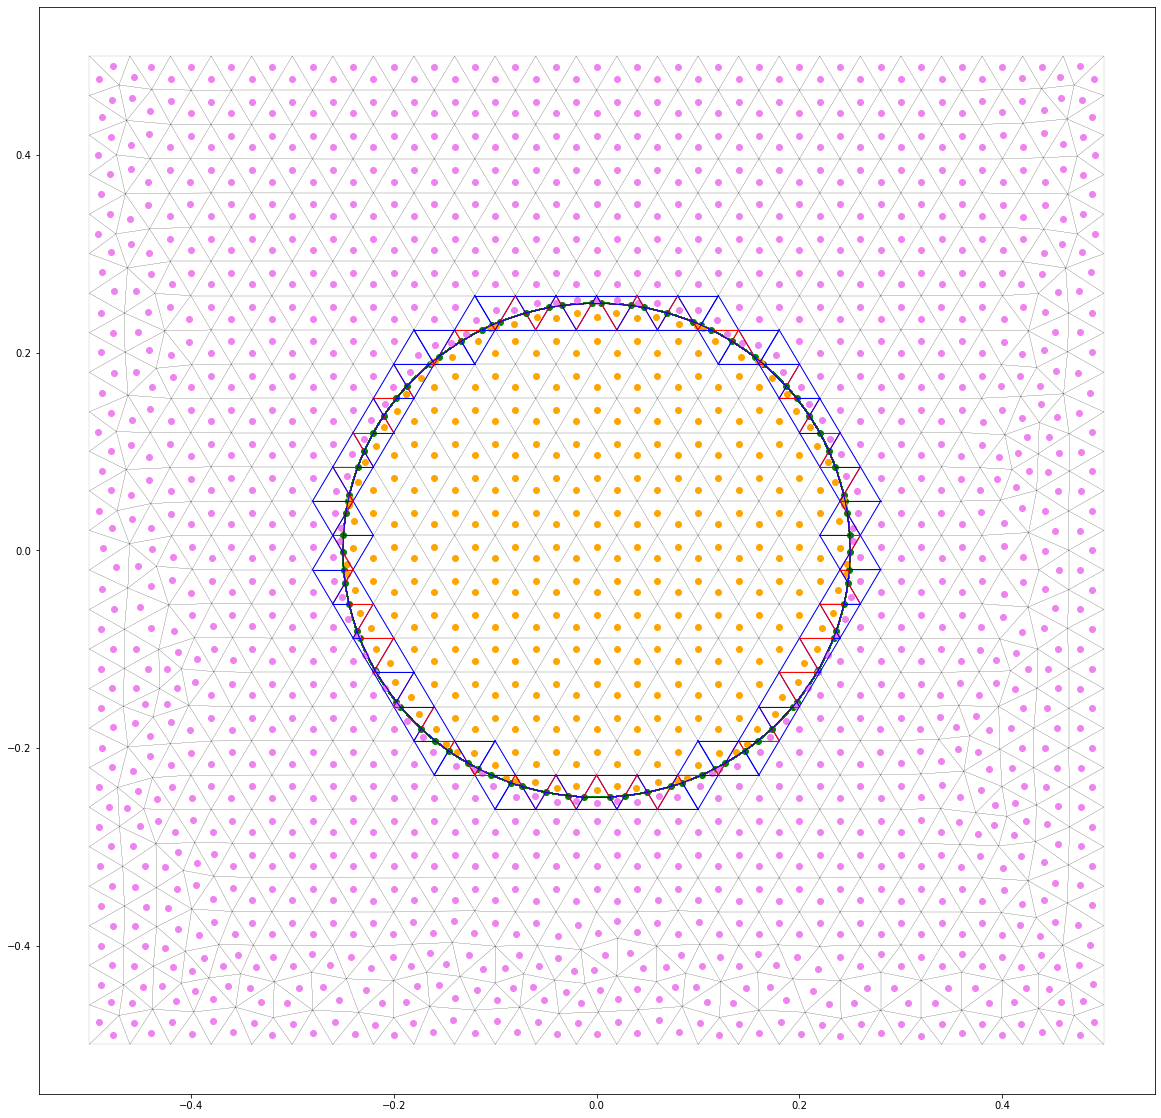

In [10]:
fig, ax = plt.subplots(figsize=(20,20))
new_Nfaces = faces.shape[0]
for ifa in range(new_Nfaces):
    if (faces[ifa,3]==-1):
        nvert = 3
    else:
        nvert = 4
    for ino in range(nvert):
       p1 = coords[faces[ifa,ino],:]
       p2 = coords[faces[ifa,(ino+1)%nvert],:]
       dx = p2-p1
       xx = [p1[0],p2[0]]
       yy = [p1[1],p2[1]]
       #ax.arrow(p1[0],p1[1], dx[0],dx[1],head_width=0.1)
       if (cut_faces[ifa]==0 or cut_faces[ifa]==1):
          ax.plot(xx,yy,'k', linewidth=0.1)
       if (cut_faces[ifa]==2 and nvert ==3):
           ax.plot(xx,yy,'r', linewidth=1)
       if (cut_faces[ifa]==2 and nvert ==4):
          ax.plot(xx,yy,'b', linewidth=1)
    circle = plt.Circle((0, 0), radius=rho, edgecolor='g', facecolor='none')
    ax.add_patch(circle)

# mark generated points
for ino in range(Npoints):
    if (ino>=Npoints_init):
        xx = coords[ino,0]
        yy = coords[ino,1]    
        point = ax.scatter(xx,yy,color='green')

# mark faces according to side
for ifa in range(Nfaces):
    if (cut_faces[ifa]!=1):
        p = barycenter(ifa)
        xx = p[0]
        yy = p[1]
        if (side_mask[ifa]==0):
            point = ax.scatter(xx,yy,color='orange')
        else:
            point = ax.scatter(xx,yy,color='violet')
#        node_per_face = np.count_nonzero(faces[ifa,:] != -1)
#        for ino in range(node_per_face):
#            idxx = glob_idx(ino)
#            xx = coords[faces[ifa,ino],0]
#            yy = coords[faces[ifa,ino],1]
#            point = ax.scatter(xx,yy,color='violet')

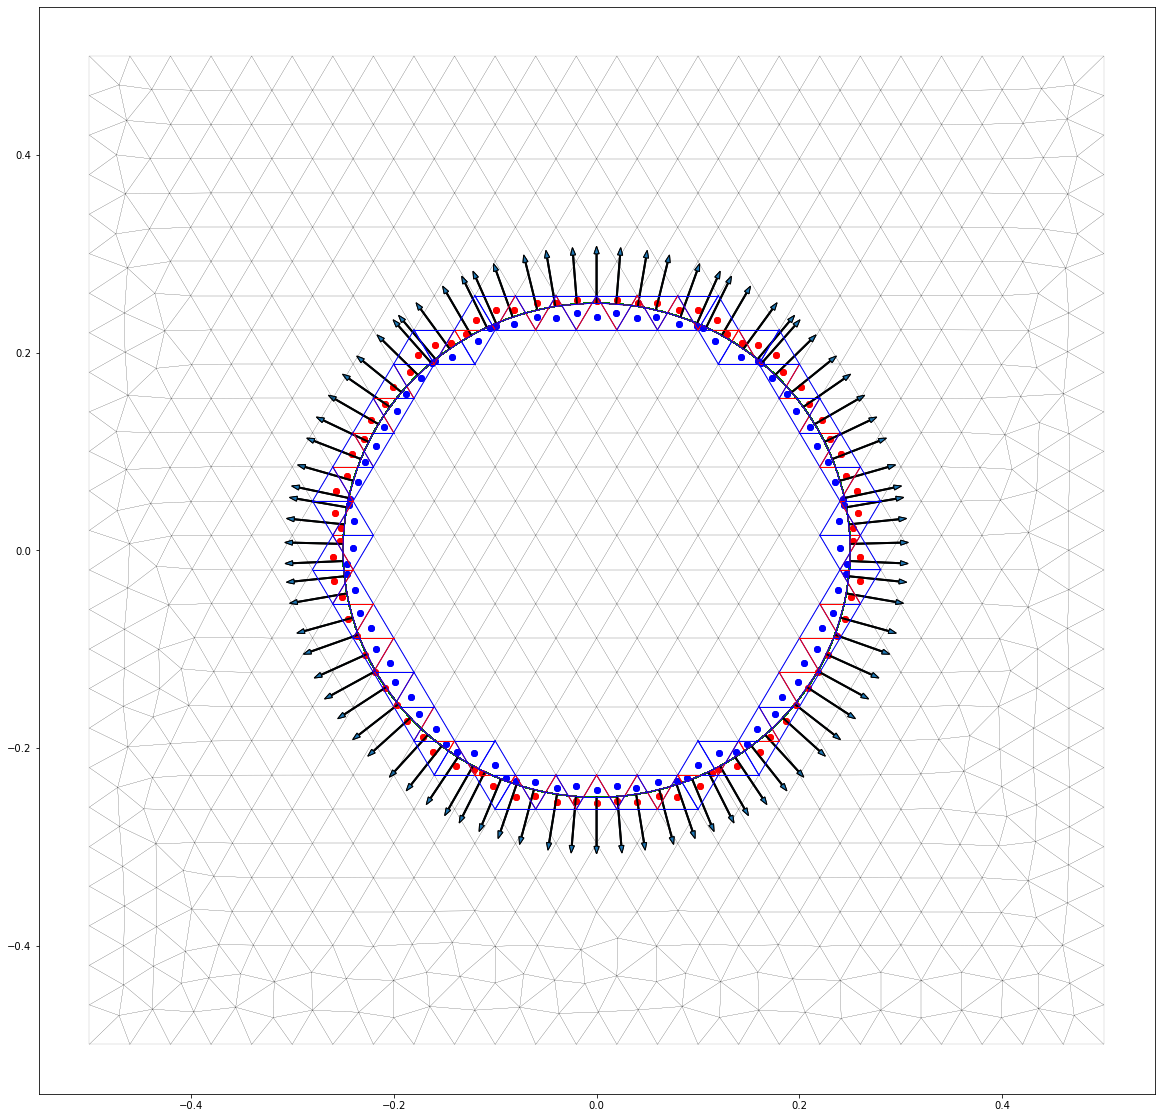

In [325]:
fig, ax = plt.subplots(figsize=(20,20))
new_Nfaces = faces.shape[0]

for ifa in range(new_Nfaces):
    if (faces[ifa,3]==-1):
        nvert = 3
    else:
        nvert = 4
    for ino in range(nvert):
       p1 = coords[faces[ifa,ino],:]
       p2 = coords[faces[ifa,(ino+1)%nvert],:]
       dx = p2-p1
       xx = [p1[0],p2[0]]
       yy = [p1[1],p2[1]]
       #ax.arrow(p1[0],p1[1], dx[0],dx[1],head_width=0.1)
       if (cut_faces[ifa]==0 or cut_faces[ifa]==1):
          ax.plot(xx,yy,'k', linewidth=0.1)
       if (cut_faces[ifa]==2 and nvert ==3):
           ax.plot(xx,yy,'r', linewidth=1)
       if (cut_faces[ifa]==2 and nvert ==4):
          ax.plot(xx,yy,'b', linewidth=1)
    circle = plt.Circle((0, 0), radius=rho, edgecolor='g', facecolor='none')
    ax.add_patch(circle)

for ied in range(gamma_edges.shape[0]):
    ifa1 = gamma_edges[ied,0]
    ifa2 = gamma_edges[ied,1]
    xx,yy = barycenter(gamma_edges[ied,0])[0:2]
    point = ax.scatter(xx,yy,color='blue')
    xx,yy = barycenter(gamma_edges[ied,1])[0:2]
    point = ax.scatter(xx,yy,color='red')
    tangent = coords[faces[ifa2,1],0:2]-coords[faces[ifa2,0],0:2]
    sign = -1
    normal = sign*np.array([[0,1],[-1,0]])@tangent 
    normal = 1/20*normal/np.linalg.norm(normal)
    midp = 0.5*(coords[faces[ifa1,0],:]+coords[faces[ifa1,1],:])
    ax.arrow(midp[0], midp[1], normal[0],normal[1],head_width=0.005)


In [139]:
# test Simpson formula
bary = np.array([0,0])
four_points=np.array([[-0.5,-0.5],[0.5,-0.5],[0.5,0.5],[-0.5,0.5]])+np.array([0.5,0.5])
fun = lambda x,y: x*y
pot = lambda x,y: 0.25*np.array([x**2*y, x*(y**2)])
#fun = lambda x,y: 1.
#pot = lambda x,y: 0.5*np.array([x-x_T[0], y-x_T[1]])
#fun = lambda x,y : x+y 
#pot = lambda x,y : np.array([y,x])
integ = 0.
for k in range(4):
                    start = four_points[k]
                    end = four_points[(k+1)%4]
                    tangent = end-start
                    normal = np.dot(np.array([[0,1],[-1,0]]), tangent)
                    n = normal/np.linalg.norm(normal)
                    #print (simpson(start, end, lambda x,y: np.dot(-n,pot(x,y))))
                    #print(-n)
                    integ = integ + simpson(start, end, lambda x,y: np.dot(n,pot(x,y)))
                    
print (integ)

0.25


In [164]:
# Discrete Gradient Matrix (dimSpace(=2) ,node_per_face)
def GR (ifa):
    node_per_face = np.count_nonzero(faces[ifa,:] != -1)
    GR = np.zeros((2, node_per_face))
    for ino in range(node_per_face):
        start1 = end2 = np.array(coords[faces[ifa][ino],0:2]) #dx
        start2 = np.array(coords[faces[ifa,(ino-1)%node_per_face], 0:2]) 
        end1   = np.array(coords[faces[ifa,(ino+1)%node_per_face], 0:2])
        tangent1 = (end1-start1)
        tangent2 = (end2-start2)
        # get normal by rotation
        normal1 = np.array([[0,1],[-1,0]])@tangent1
        normal2 = np.array([[0,1],[-1,0]])@tangent2
        norm1 = normal1/np.linalg.norm(normal1)
        norm2 = normal2/np.linalg.norm(normal2)
        mod_F = calc_surface(ifa)
        GR[:,ino] = 0.5/mod_F*(normal1+normal2)
    return GR

In [165]:
# Potential RECONSTRUCTION matrix (node_per_face, node_per_face)
def recpot (ifa):
  global Nfaces, faces
  node_per_face = np.count_nonzero(faces[ifa,:] != -1)
  dim_basis     = 3 #dimension of basis of R,c2(T) 
  V = np.zeros ((node_per_face, dim_basis)) #evaluation matrix
  M = np.zeros ((dim_basis, dim_basis))     #the mass matrix to invert
  B1 = np.zeros ((dim_basis,node_per_face))  #the rhs matrix (part 1)
  B2 = np.zeros ((dim_basis,node_per_face))  #the rhs matrix (part 2)
  x_T = barycenter(ifa)
  #define the psi_i (for edge contribution of B)
  psi = [None for _ in range(dim_basis)]
  psi [0] = lambda x,y:  np.array([x-x_T[0],y-x_T[1]])
  psi [1] = lambda x,y:  np.array([x-x_T[0],y-x_T[1]])*(x-x_T[0])
  psi [2] = lambda x,y:  np.array([x-x_T[0],y-x_T[1]])*(y-x_T[1])
  #define the phi_i (for V)
  phi = [None for _ in range(dim_basis)]
  phi [0] = lambda x,y: 2.
  phi [1] = lambda x,y: 3*(x - x_T[0])
  phi [2] = lambda x,y: 3*(y - x_T[1])
  #define the csi_ij (integrated phi_i*phi_j, for M)
  csi = [[None for _ in range(dim_basis)] for _ in range (dim_basis)]
  csi [0][0] = lambda x,y: np.array([2*(x-x_T[0]), 
                                       2*(y-x_T[1])])
  csi [0][1] = csi[1][0] = lambda x,y: np.array([0., 
                                                   6*(y-x_T[1])*(x-x_T[0])])
  csi [0][2] = csi[2][0] = lambda x,y: np.array([6*(x-x_T[0])*(y-x_T[1]),
                                                   0.])
  csi [1][1] = lambda x,y: np.array([0., 
                                       9*(y-x_T[1])*((x-x_T[0])**2)])
  csi [1][2] = csi[2][1] = lambda x,y: np.array([(9/4)*((x-x_T[0])**2)*(y-x_T[1]), 
                                                   (9/4)*(x-x_T[0])*((y-x_T[1])**2)])
  csi [2][2] = lambda x,y: np.array([9*(x-x_T[0])*((y-x_T[1])**2),
                                       0.])
  #define the chi_iN  (for cell contribution in B)
  chi_fac = [None for _ in range (dim_basis)]
        #visualization
        #if (t == -1):
        #  fig,ax = plt.subplots(figsize=(4,4))
         #   plt.gca().set_aspect('equal', adjustable='box')
          #  start1 = end2 = np.array(nodes[elements[t][j]]) #dx
           # start2 = np.array(nodes[elements[t][(j-1)%node_per_elem]]) #sx
            #end1 = np.array(nodes[elements[t][(j+1)%node_per_elem]])
           # ax.plot([start1[0], end1[0]], [start1[1], end1[1]],'r')
           # ax.plot([start2[0], end2[0]], [start2[1], end2[1]],'r')
            #ax.plot ([start1[0],start1[0]+ e_avg[0] ],
             #        [start1[1],start1[1]+ e_avg[1]])
  chi_fac[0] = lambda  x,y: np.array([(x-x_T[0])*(y-x_T[1]),
                                        (x-x_T[0])*(y-x_T[1])]) 
  chi_fac[1] = lambda  x,y: np.array([0.5*((x-x_T[0])**2)*(y-x_T[1]),
                                        (y-x_T[1])*((x-x_T[0])**2)]) 
  chi_fac[2] = lambda  x,y: np.array([(x-x_T[0])*((y-x_T[1])**2),
                                        0.5*((y-x_T[1])**2)*(x-x_T[0])]) 
  #fill V  
  for i in range(node_per_face):
        xx = coords[faces[ifa][i]][0]
        yy = coords[faces[ifa][i]][1]
        for j in range(dim_basis):
            V[i][j] = phi[j](xx,yy)
    #fill M
  for i in range (dim_basis):
        for j in range (dim_basis):
            #must sum integrals over E of csi*n 
            for k in range(node_per_face):
                # get direction of edge
                start = coords[faces[ifa][k], 0:2]
                end   = coords[faces[ifa][(k+1)%node_per_face], 0:2]
                tangent = (end-start)/np.linalg.norm(end-start)
                # get normal by rotation
                normal = np.array([[0,1],[-1,0]])@tangent
                M [i][j] = M [i][j] + simpson(start, end, lambda x,y: np.dot(normal,csi[i][j] (x,y)))
  #fill B
  for i in range(dim_basis):
        for j in range (node_per_face):
                #face contribution form left and right (need 2 normals)
                start1 = end2 = np.array(coords[faces[ifa][j],0:2]) #dx
                start2 = np.array(coords[faces[ifa][(j-1)%node_per_face], 0:2]) #sx
                end1   = np.array(coords[faces[ifa][(j+1)%node_per_face], 0:2])
                tangent1 = (end1-start1)
                tangent2 = (end2-start2)
                # get normal by rotation
                normal1 = np.array([[0,1],[-1,0]])@tangent1
                normal2 = np.array([[0,1],[-1,0]])@tangent2
                norm1 = normal1/np.linalg.norm(normal1)
                norm2 = normal2/np.linalg.norm(normal2)
                B2 [i][j] = B2 [i][j] + simpson(start1, end1,
                                              lambda x,y: np.dot(norm1,psi[i](x,y)), True, 'minus')#dx
                B2 [i][j] = B2 [i][j] + simpson(start2, end2, 
                                              lambda x,y: np.dot(norm2,psi[i](x,y)), True, 'plus')#sx 
                #cell contribution: must sum integrals over E of chi*n 
                e_avg = 0.5*(normal1 + normal2)
                chi_ij = lambda x,y: np.multiply (np.flip(e_avg), chi_fac[i](x,y))
                for k in range(node_per_face):
                    start = coords[faces[ifa][k],0:2]
                    end = coords[faces[ifa][(k+1)%node_per_face], 0:2]
                    tangent = (end-start)/np.linalg.norm(end-start)
                    # get normal by rotation
                    normal = np.array([[0,1],[-1,0]])@tangent
                    # get surface of face
                    mod_F = calc_surface (ifa)
                    B1[i][j] = B1[i][j] -(1/mod_F)* simpson(start, end, lambda x,y: np.dot(normal,chi_ij(x,y)))
  #calculate the final local matrix S an store it
  R = np.dot(V, np.linalg.solve(M,(B1+B2)))
  return R

In [142]:
# test reconstruction: initialize poli1 function and check gradient and recpot 
# recpot should be exact for pol1

u = np.zeros(Npoints)
for ino in range(Npoints):
    x = coords[ino,0]
    y = coords[ino,0]
    u[ino] = x + y

for ifa in range(Nfaces):
    print ("Face no:", ifa)
    node_per_face = np.count_nonzero(faces[ifa,:] != -1)
    u_F = u[faces[ifa,0:node_per_face]]
    grad = GR(ifa)
    print("Nodal values", u_F)
    print ("Gradient: ", np.dot(grad,u_F))
    R = recpot(ifa)
    print("Reconstruction", np.dot(R,u_F))
    print ("*************")
    if (np.linalg.norm( u_F- np.dot(R,u_F) )>1e-6):
        print ("Error")

Face no: 0
Nodal values [-0.92080542 -0.83798144 -0.87874541]
Gradient:  [2.00000000e+00 1.77635684e-15]
Reconstruction [-0.92080542 -0.83798144 -0.87874541]
*************
Face no: 1
Nodal values [0.92801037 0.93031469 0.85058681]
Gradient:  [2. 0.]
Reconstruction [0.92801037 0.93031469 0.85058681]
*************
Face no: 2
Nodal values [-0.84000001 -0.88133059 -0.9247112 ]
Gradient:  [2.00000000e+00 3.55271368e-15]
Reconstruction [-0.84000001 -0.88133059 -0.9247112 ]
*************
Face no: 3
Nodal values [0.92850482 0.93071797 0.85053771]
Gradient:  [2. 0.]
Reconstruction [0.92850482 0.93071797 0.85053771]
*************
Face no: 4
Nodal values [0.93071797 0.9307114  0.85158552]
Gradient:  [2. 0.]
Reconstruction [0.93071797 0.9307114  0.85158552]
*************
Face no: 5
Nodal values [-0.93071797 -0.86300231 -0.84329784]
Gradient:  [ 2.00000000e+00 -3.55271368e-15]
Reconstruction [-0.93071797 -0.86300231 -0.84329784]
*************
Face no: 6
Nodal values [-0.87874541 -0.9450351  -0.9208

Reconstruction [0.72396667 0.63932685 0.67841335]
*************
Face no: 56
Nodal values [-0.63547262 -0.70181968 -0.71145181]
Gradient:  [2. 0.]
Reconstruction [-0.63547262 -0.70181968 -0.71145181]
*************
Face no: 57
Nodal values [-0.08254359 -0.1438097  -0.15145182]
Gradient:  [2. 0.]
Reconstruction [-0.08254359 -0.1438097  -0.15145182]
*************
Face no: 58
Nodal values [-0.03087673 -0.02285626  0.04      ]
Gradient:  [ 2.00000000e+00 -1.11022302e-16]
Reconstruction [-0.03087673 -0.02285626  0.04      ]
*************
Face no: 59
Nodal values [-0.32865097 -0.3347411  -0.40000001]
Gradient:  [2. 0.]
Reconstruction [-0.32865097 -0.3347411  -0.40000001]
*************
Face no: 60
Nodal values [0.24466198 0.17551904 0.16865097]
Gradient:  [2. 0.]
Reconstruction [0.24466198 0.17551904 0.16865097]
*************
Face no: 61
Nodal values [0.87161898 0.87083805 0.79999999]
Gradient:  [2. 0.]
Reconstruction [0.87161898 0.87083805 0.79999999]
*************
Face no: 62
Nodal values [0.

Reconstruction [-0.24       -0.16000001 -0.2       ]
*************
Face no: 116
Nodal values [0.11999999 0.16       0.08      ]
Gradient:  [2. 0.]
Reconstruction [0.11999999 0.16       0.08      ]
*************
Face no: 117
Nodal values [-0.52       -0.56000001 -0.48      ]
Gradient:  [2. 0.]
Reconstruction [-0.52       -0.56000001 -0.48      ]
*************
Face no: 118
Nodal values [-0.6        -0.68001483 -0.64000001]
Gradient:  [ 2.00000000e+00 -1.77635684e-15]
Reconstruction [-0.6        -0.68001483 -0.64000001]
*************
Face no: 119
Nodal values [0.35999999 0.31999999 0.27999999]
Gradient:  [2. 0.]
Reconstruction [0.35999999 0.31999999 0.27999999]
*************
Face no: 120
Nodal values [-4.00000008e-02 -8.00000055e-02 -8.45611453e-09]
Gradient:  [2. 0.]
Reconstruction [-4.00000008e-02 -8.00000055e-02 -8.45611452e-09]
*************
Face no: 121
Nodal values [-0.6        -0.64000436 -0.56      ]
Gradient:  [ 2.00000000e+00 -1.77635684e-15]
Reconstruction [-0.6        -0.64000

Reconstruction [-0.44000001 -0.48000001 -0.40000001]
*************
Face no: 177
Nodal values [0.11999999 0.03999999 0.07999999]
Gradient:  [ 2.00000000e+00 -1.11022302e-16]
Reconstruction [0.11999999 0.03999999 0.07999999]
*************
Face no: 178
Nodal values [-0.08000001 -0.04000001 -0.12000001]
Gradient:  [2. 0.]
Reconstruction [-0.08000001 -0.04000001 -0.12000001]
*************
Face no: 179
Nodal values [0.59999999 0.63997438 0.55999999]
Gradient:  [2. 0.]
Reconstruction [0.59999999 0.63997438 0.55999999]
*************
Face no: 180
Nodal values [-0.40000001 -0.36000001 -0.32000001]
Gradient:  [2. 0.]
Reconstruction [-0.40000001 -0.36000001 -0.32000001]
*************
Face no: 181
Nodal values [0.23999999 0.19999999 0.15999999]
Gradient:  [2. 0.]
Reconstruction [0.23999999 0.19999999 0.15999999]
*************
Face no: 182
Nodal values [-0.6        -0.56000001 -0.52      ]
Gradient:  [2. 0.]
Reconstruction [-0.6        -0.56000001 -0.52      ]
*************
Face no: 183
Nodal values

Reconstruction [0.71999999 0.7596285  0.79777104]
*************
Face no: 239
Nodal values [0.76012933 0.68000722 0.71993966]
Gradient:  [2.00000000e+00 1.77635684e-15]
Reconstruction [0.76012933 0.68000722 0.71993966]
*************
Face no: 240
Nodal values [-0.4  -0.36 -0.32]
Gradient:  [2. 0.]
Reconstruction [-0.4  -0.36 -0.32]
*************
Face no: 241
Nodal values [-0.52000001 -0.59998971 -0.56000001]
Gradient:  [2. 0.]
Reconstruction [-0.52000001 -0.59998971 -0.56000001]
*************
Face no: 242
Nodal values [0.51999999 0.55999999 0.59999999]
Gradient:  [2. 0.]
Reconstruction [0.51999999 0.55999999 0.59999999]
*************
Face no: 243
Nodal values [-0.64000001 -0.55999692 -0.60000001]
Gradient:  [ 2.00000000e+00 -1.77635684e-15]
Reconstruction [-0.64000001 -0.55999692 -0.60000001]
*************
Face no: 244
Nodal values [0.16 0.24 0.2 ]
Gradient:  [2. 0.]
Reconstruction [0.16 0.24 0.2 ]
*************
Face no: 245
Nodal values [0.71993966 0.68000722 0.63997438]
Gradient:  [2. 

Reconstruction [0.07999999 0.15999999 0.11999999]
*************
Face no: 300
Nodal values [-0.71933116 -0.67988854 -0.64000001]
Gradient:  [2. 0.]
Reconstruction [-0.71933116 -0.67988854 -0.64000001]
*************
Face no: 301
Nodal values [-0.44000001 -0.36000002 -0.40000001]
Gradient:  [2. 0.]
Reconstruction [-0.44000001 -0.36000002 -0.40000001]
*************
Face no: 302
Nodal values [0.47999999 0.51983118 0.55999999]
Gradient:  [2. 0.]
Reconstruction [0.47999999 0.51983118 0.55999999]
*************
Face no: 303
Nodal values [0.59999999 0.55999999 0.63999999]
Gradient:  [2. 0.]
Reconstruction [0.59999999 0.55999999 0.63999999]
*************
Face no: 304
Nodal values [-0.59998143 -0.55999692 -0.64000001]
Gradient:  [ 2.00000000e+00 -3.55271368e-15]
Reconstruction [-0.59998143 -0.55999692 -0.64000001]
*************
Face no: 305
Nodal values [0.43999999 0.51999999 0.47999999]
Gradient:  [2.0000000e+00 8.8817842e-16]
Reconstruction [0.43999999 0.51999999 0.47999999]
*************
Face n

Reconstruction [-0.93071797 -0.86771243 -0.93399045]
*************
Face no: 354
Nodal values [-0.60000001 -0.68000001 -0.64000001]
Gradient:  [2. 0.]
Reconstruction [-0.60000001 -0.68000001 -0.64000001]
*************
Face no: 355
Nodal values [0.35999999 0.39999999 0.43999999]
Gradient:  [2. 0.]
Reconstruction [0.35999999 0.39999999 0.43999999]
*************
Face no: 356
Nodal values [0.11999999 0.03999999 0.07999999]
Gradient:  [ 2.00000000e+00 -2.22044605e-16]
Reconstruction [0.11999999 0.03999999 0.07999999]
*************
Face no: 357
Nodal values [-0.32000001 -0.28000001 -0.24000001]
Gradient:  [2. 0.]
Reconstruction [-0.32000001 -0.28000001 -0.24000001]
*************
Face no: 358
Nodal values [-0.48000001 -0.52000001 -0.56000001]
Gradient:  [2. 0.]
Reconstruction [-0.48000001 -0.52000001 -0.56000001]
*************
Face no: 359
Nodal values [0.86213151 0.79513703 0.86155186]
Gradient:  [ 2.00000000e+00 -9.99200722e-16]
Reconstruction [0.86213151 0.79513703 0.86155186]
*************

Reconstruction [-0.36000001 -0.28000001 -0.32000001]
*************
Face no: 412
Nodal values [-0.20000001 -0.24000001 -0.16000001]
Gradient:  [ 2.0000000e+00 -4.4408921e-16]
Reconstruction [-0.20000001 -0.24000001 -0.16000001]
*************
Face no: 413
Nodal values [0.67990666 0.63994182 0.71986231]
Gradient:  [2. 0.]
Reconstruction [0.67990666 0.63994182 0.71986231]
*************
Face no: 414
Nodal values [0.39999999 0.43999999 0.35999999]
Gradient:  [2.0000000e+00 8.8817842e-16]
Reconstruction [0.39999999 0.43999999 0.35999999]
*************
Face no: 415
Nodal values [-0.08000002 -0.04000001 -0.12000001]
Gradient:  [ 2.00000000e+00 -2.22044605e-16]
Reconstruction [-0.08000002 -0.04000001 -0.12000001]
*************
Face no: 416
Nodal values [-0.64000001 -0.72000001 -0.68000001]
Gradient:  [2. 0.]
Reconstruction [-0.64000001 -0.72000001 -0.68000001]
*************
Face no: 417
Nodal values [-1.         -0.93399045 -1.        ]
Gradient:  [2. 0.]
Reconstruction [-1.         -0.93399045 

Reconstruction [-0.12000001 -0.16000001 -0.08000001]
*************
Face no: 466
Nodal values [0.92850482 0.93071797 1.        ]
Gradient:  [2. 0.]
Reconstruction [0.92850482 0.93071797 1.        ]
*************
Face no: 467
Nodal values [1.         0.92854177 1.        ]
Gradient:  [2. 0.]
Reconstruction [1.         0.92854177 1.        ]
*************
Face no: 468
Nodal values [-0.64 -0.6  -0.56]
Gradient:  [2. 0.]
Reconstruction [-0.64 -0.6  -0.56]
*************
Face no: 469
Nodal values [-0.24000001 -0.20000001 -0.16000001]
Gradient:  [2. 0.]
Reconstruction [-0.24000001 -0.20000001 -0.16000001]
*************
Face no: 470
Nodal values [0.23999999 0.27999999 0.31999999]
Gradient:  [2. 0.]
Reconstruction [0.23999999 0.27999999 0.31999999]
*************
Face no: 471
Nodal values [-0.75920111 -0.71984829 -0.67988854]
Gradient:  [2. 0.]
Reconstruction [-0.75920111 -0.71984829 -0.67988854]
*************
Face no: 472
Nodal values [-0.84025537 -0.87550642 -0.79984158]
Gradient:  [2. 0.]
Reco

Reconstruction [-0.68       -0.71145181 -0.76      ]
*************
Face no: 569
Nodal values [-0.76       -0.79410028 -0.84      ]
Gradient:  [ 2.00000000e+00 -3.55271368e-15]
Reconstruction [-0.76       -0.79410028 -0.84      ]
*************
Face no: 570
Nodal values [1.         0.92801037 1.        ]
Gradient:  [2. 0.]
Reconstruction [1.         0.92801037 1.        ]
*************
Face no: 571
Nodal values [0.93230898 0.93031469 1.        ]
Gradient:  [2. 0.]
Reconstruction [0.93230898 0.93031469 1.        ]
*************
Face no: 572
Nodal values [0.92801037 0.91899626 1.        ]
Gradient:  [2. 0.]
Reconstruction [0.92801037 0.91899626 1.        ]
*************
Face no: 573
Nodal values [-0.71145181 -0.79410028 -0.76      ]
Gradient:  [2. 0.]
Reconstruction [-0.71145181 -0.79410028 -0.76      ]
*************
Face no: 574
Nodal values [1.         0.93031469 0.92801037]
Gradient:  [2. 0.]
Reconstruction [1.         0.93031469 0.92801037]
*************
Face no: 575
Nodal values [-0.6

Nodal values [0.63913181 0.67985529 0.59999999]
Gradient:  [2.00000000e+00 1.77635684e-15]
Reconstruction [0.63913181 0.67985529 0.59999999]
*************
Face no: 630
Nodal values [0.55999999 0.59898711 0.63913181]
Gradient:  [2.00000000e+00 3.55271368e-15]
Reconstruction [0.55999999 0.59898711 0.63913181]
*************
Face no: 631
Nodal values [-0.93071797 -0.93399045 -1.        ]
Gradient:  [2. 0.]
Reconstruction [-0.93071797 -0.93399045 -1.        ]
*************
Face no: 632
Nodal values [0.79489961 0.85053771 0.75999385]
Gradient:  [ 2.00000000e+00 -1.77635684e-15]
Reconstruction [0.79489961 0.85053771 0.75999385]
*************
Face no: 633
Nodal values [-0.64000001 -0.67669379 -0.60000001]
Gradient:  [2. 0.]
Reconstruction [-0.64000001 -0.67669379 -0.60000001]
*************
Face no: 634
Nodal values [0.47999999 0.51999509 0.55998748]
Gradient:  [2. 0.]
Reconstruction [0.47999999 0.51999509 0.55998748]
*************
Face no: 635
Nodal values [ 7.99999815e-02  3.99999828e-02 -2.0

Reconstruction [0.75999385 0.79857801 0.71999751]
*************
Face no: 684
Nodal values [-0.6797456  -0.71775899 -0.75450543]
Gradient:  [2. 0.]
Reconstruction [-0.6797456  -0.71775899 -0.75450543]
*************
Face no: 685
Nodal values [-1.         -0.93111654 -0.93071797]
Gradient:  [2. 0.]
Reconstruction [-1.         -0.93111654 -0.93071797]
*************
Face no: 686
Nodal values [-0.48000001 -0.40000001 -0.44000001]
Gradient:  [2.0000000e+00 8.8817842e-16]
Reconstruction [-0.48000001 -0.40000001 -0.44000001]
*************
Face no: 687
Nodal values [-0.40000001 -0.48000001 -0.44000001]
Gradient:  [2. 0.]
Reconstruction [-0.40000001 -0.48000001 -0.44000001]
*************
Face no: 688
Nodal values [-0.56000001 -0.64000001 -0.60000001]
Gradient:  [ 2.00000000e+00 -1.77635684e-15]
Reconstruction [-0.56000001 -0.64000001 -0.60000001]
*************
Face no: 689
Nodal values [-0.15145182 -0.24       -0.2       ]
Gradient:  [2. 0.]
Reconstruction [-0.15145182 -0.24       -0.2       ]
**

Reconstruction [0.27999999 0.23999999 0.31999999]
*************
Face no: 741
Nodal values [0.67989884 0.59998313 0.63999999]
Gradient:  [ 2.00000000e+00 -1.77635684e-15]
Reconstruction [0.67989884 0.59998313 0.63999999]
*************
Face no: 742
Nodal values [-4.00000080e-02 -8.39779446e-09  3.99999917e-02]
Gradient:  [2.00000000e+00 2.43430916e-17]
Reconstruction [-4.00000080e-02 -8.39779446e-09  3.99999917e-02]
*************
Face no: 743
Nodal values [0.51999999 0.47999999 0.43999999]
Gradient:  [2. 0.]
Reconstruction [0.51999999 0.47999999 0.43999999]
*************
Face no: 744
Nodal values [0.43999999 0.47999984 0.39999999]
Gradient:  [2. 0.]
Reconstruction [0.43999999 0.47999984 0.39999999]
*************
Face no: 745
Nodal values [-0.40000001 -0.36342614 -0.32000002]
Gradient:  [2. 0.]
Reconstruction [-0.40000001 -0.36342614 -0.32000002]
*************
Face no: 746
Nodal values [0.67999998 0.75999998 0.71999998]
Gradient:  [2. 0.]
Reconstruction [0.67999998 0.75999998 0.71999998]


Nodal values [-1.         -0.92080542 -1.        ]
Gradient:  [2. 0.]
Reconstruction [-1.         -0.92080542 -1.        ]
*************
Face no: 804
Nodal values [1.        0.9247782 1.       ]
Gradient:  [2. 0.]
Reconstruction [1.        0.9247782 1.       ]
*************
Face no: 805
Nodal values [-1.         -0.93071797 -1.        ]
Gradient:  [2. 0.]
Reconstruction [-1.         -0.93071797 -1.        ]
*************
Face no: 806
Nodal values [-0.6  -0.56 -0.52]
Gradient:  [2. 0.]
Reconstruction [-0.6  -0.56 -0.52]
*************
Face no: 807
Nodal values [-0.36 -0.32 -0.28]
Gradient:  [2. 0.]
Reconstruction [-0.36 -0.32 -0.28]
*************
Face no: 808
Nodal values [0.28 0.32 0.36]
Gradient:  [2. 0.]
Reconstruction [0.28 0.32 0.36]
*************
Face no: 809
Nodal values [1.         0.93071797 1.        ]
Gradient:  [2. 0.]
Reconstruction [1.         0.93071797 1.        ]
*************
Face no: 810
Nodal values [-1.         -0.92371767 -1.        ]
Gradient:  [2. 0.]
Reconstructi

Reconstruction [0.23999999 0.27999999 0.31999999]
*************
Face no: 867
Nodal values [0.19999999 0.23999999 0.27999999]
Gradient:  [2.0000000e+00 8.8817842e-16]
Reconstruction [0.19999999 0.23999999 0.27999999]
*************
Face no: 868
Nodal values [-0.60000001 -0.56000001 -0.64000001]
Gradient:  [2. 0.]
Reconstruction [-0.60000001 -0.56000001 -0.64000001]
*************
Face no: 869
Nodal values [-0.08 -0.16 -0.12]
Gradient:  [2.0000000e+00 4.4408921e-16]
Reconstruction [-0.08 -0.16 -0.12]
*************
Face no: 870
Nodal values [0.59999998 0.63999998 0.55999998]
Gradient:  [2.00000000e+00 1.77635684e-15]
Reconstruction [0.59999998 0.63999998 0.55999998]
*************
Face no: 871
Nodal values [0.51999998 0.55999999 0.59999998]
Gradient:  [2.00000000e+00 3.55271368e-15]
Reconstruction [0.51999998 0.55999999 0.59999998]
*************
Face no: 872
Nodal values [0.47999998 0.51999998 0.43999999]
Gradient:  [2. 0.]
Reconstruction [0.47999998 0.51999998 0.43999999]
*************
Face

Nodal values [0.71431518 0.75420138 0.67985529]
Gradient:  [ 2.00000000e+00 -1.77635684e-15]
Reconstruction [0.71431518 0.75420138 0.67985529]
*************
Face no: 929
Nodal values [-0.56000001 -0.52000001 -0.60000001]
Gradient:  [2.0000000e+00 8.8817842e-16]
Reconstruction [-0.56000001 -0.52000001 -0.60000001]
*************
Face no: 930
Nodal values [-0.12000001 -0.16       -0.2       ]
Gradient:  [2. 0.]
Reconstruction [-0.12000001 -0.16       -0.2       ]
*************
Face no: 931
Nodal values [ 3.99999924e-02 -7.45167189e-09 -4.00000072e-02]
Gradient:  [ 2.00000000e+00 -4.55715902e-17]
Reconstruction [ 3.99999924e-02 -7.45167189e-09 -4.00000072e-02]
*************
Face no: 932
Nodal values [-0.12000002 -0.16000002 -0.08000002]
Gradient:  [2. 0.]
Reconstruction [-0.12000002 -0.16000002 -0.08000002]
*************
Face no: 933
Nodal values [-0.64000001 -0.59988707 -0.6797456 ]
Gradient:  [2. 0.]
Reconstruction [-0.64000001 -0.59988707 -0.6797456 ]
*************
Face no: 934
Nodal va

Reconstruction [0.71939309 0.75927508 0.67989884]
*************
Face no: 988
Nodal values [-0.08 -0.12 -0.16]
Gradient:  [ 2.0000000e+00 -4.4408921e-16]
Reconstruction [-0.08 -0.12 -0.16]
*************
Face no: 989
Nodal values [0.27999999 0.31999999 0.35999999]
Gradient:  [ 2.00000000e+00 -1.77635684e-15]
Reconstruction [0.27999999 0.31999999 0.35999999]
*************
Face no: 990
Nodal values [-0.28       -0.32000001 -0.24000001]
Gradient:  [2.0000000e+00 8.8817842e-16]
Reconstruction [-0.28       -0.32000001 -0.24000001]
*************
Face no: 991
Nodal values [0.35999999 0.39999999 0.43999999]
Gradient:  [2. 0.]
Reconstruction [0.35999999 0.39999999 0.43999999]
*************
Face no: 992
Nodal values [0.59999999 0.63999999 0.55999999]
Gradient:  [ 2.00000000e+00 -1.77635684e-15]
Reconstruction [0.59999999 0.63999999 0.55999999]
*************
Face no: 993
Nodal values [0.03999999 0.11999999 0.07999999]
Gradient:  [2. 0.]
Reconstruction [0.03999999 0.11999999 0.07999999]
************

Reconstruction [0.43999999 0.35999999 0.39999999]
*************
Face no: 1048
Nodal values [0.59999999 0.55998748 0.63994182]
Gradient:  [2.00000000e+00 1.77635684e-15]
Reconstruction [0.59999999 0.55998748 0.63994182]
*************
Face no: 1049
Nodal values [0.39999999 0.43999999 0.35999999]
Gradient:  [2. 0.]
Reconstruction [0.39999999 0.43999999 0.35999999]
*************
Face no: 1050
Nodal values [0.15999999 0.23999999 0.19999999]
Gradient:  [2. 0.]
Reconstruction [0.15999999 0.23999999 0.19999999]
*************
Face no: 1051
Nodal values [0.47999999 0.51999998 0.43999998]
Gradient:  [ 2.0000000e+00 -8.8817842e-16]
Reconstruction [0.47999999 0.51999998 0.43999998]
*************
Face no: 1052
Nodal values [-0.68000001 -0.71982448 -0.75957399]
Gradient:  [2. 0.]
Reconstruction [-0.68000001 -0.71982448 -0.75957399]
*************
Face no: 1053
Nodal values [0.23999999 0.19999999 0.15999999]
Gradient:  [2. 0.]
Reconstruction [0.23999999 0.19999999 0.15999999]
*************
Face no: 105

Nodal values [-0.16000002 -0.24000002 -0.20000002]
Gradient:  [ 2.0000000e+00 -4.4408921e-16]
Reconstruction [-0.16000002 -0.24000002 -0.20000002]
*************
Face no: 1110
Nodal values [0.39999999 0.35999999 0.43999999]
Gradient:  [ 2.0000000e+00 -8.8817842e-16]
Reconstruction [0.39999999 0.35999999 0.43999999]
*************
Face no: 1111
Nodal values [0.71999999 0.76012933 0.80059911]
Gradient:  [ 2.00000000e+00 -3.55271368e-15]
Reconstruction [0.71999999 0.76012933 0.80059911]
*************
Face no: 1112
Nodal values [-4.00000184e-02  3.99999828e-02 -1.56574932e-08]
Gradient:  [2.00000000e+00 1.11022302e-16]
Reconstruction [-4.00000184e-02  3.99999828e-02 -1.56574932e-08]
*************
Face no: 1113
Nodal values [0.27999999 0.19999999 0.23999999]
Gradient:  [2. 0.]
Reconstruction [0.27999999 0.19999999 0.23999999]
*************
Face no: 1114
Nodal values [0.11999999 0.15999999 0.07999999]
Gradient:  [2.0000000e+00 4.4408921e-16]
Reconstruction [0.11999999 0.15999999 0.07999999]
**

Reconstruction [-0.36000002 -0.28000002 -0.32000001]
*************
Face no: 1170
Nodal values [-0.16       -0.2        -0.12000001]
Gradient:  [2. 0.]
Reconstruction [-0.16       -0.2        -0.12000001]
*************
Face no: 1171
Nodal values [-0.68000001 -0.64000001 -0.72000001]
Gradient:  [2. 0.]
Reconstruction [-0.68000001 -0.64000001 -0.72000001]
*************
Face no: 1172
Nodal values [-0.64000001 -0.68001483 -0.72000001]
Gradient:  [2. 0.]
Reconstruction [-0.64000001 -0.68001483 -0.72000001]
*************
Face no: 1173
Nodal values [0.63999999 0.68000722 0.71999999]
Gradient:  [ 2.00000000e+00 -3.55271368e-15]
Reconstruction [0.63999999 0.68000722 0.71999999]
*************
Face no: 1174
Nodal values [-0.72006138 -0.68001483 -0.64000436]
Gradient:  [2. 0.]
Reconstruction [-0.72006138 -0.68001483 -0.64000436]
*************
Face no: 1175
Nodal values [-0.76002323 -0.68001483 -0.72006138]
Gradient:  [2. 0.]
Reconstruction [-0.76002323 -0.68001483 -0.72006138]
*************
Face no

Reconstruction [-8.90555452e-09  3.99999915e-02  7.99999906e-02]
*************
Face no: 1230
Nodal values [-0.12000001 -0.16000001 -0.2       ]
Gradient:  [ 2.0000000e+00 -8.8817842e-16]
Reconstruction [-0.12000001 -0.16000001 -0.2       ]
*************
Face no: 1231
Nodal values [-7.45167189e-09 -4.00000068e-02 -8.00000067e-02]
Gradient:  [2. 0.]
Reconstruction [-7.45167187e-09 -4.00000068e-02 -8.00000067e-02]
*************
Face no: 1232
Nodal values [0.19999999 0.11999999 0.15999999]
Gradient:  [2. 0.]
Reconstruction [0.19999999 0.11999999 0.15999999]
*************
Face no: 1233
Nodal values [-0.04000001 -0.08000001 -0.12000001]
Gradient:  [ 2.0000000e+00 -4.4408921e-16]
Reconstruction [-0.04000001 -0.08000001 -0.12000001]
*************
Face no: 1234
Nodal values [-0.04000001 -0.12000001 -0.08000001]
Gradient:  [2. 0.]
Reconstruction [-0.04000001 -0.12000001 -0.08000001]
*************
Face no: 1235
Nodal values [-8.45611453e-09 -8.00000055e-02 -4.00000104e-02]
Gradient:  [ 2.00000000

Reconstruction [0.86822113 0.79280442 0.86213151]
*************
Face no: 1293
Nodal values [0.71939309 0.8049155  0.75927508]
Gradient:  [ 2.00000000e+00 -1.77635684e-15]
Reconstruction [0.71939309 0.8049155  0.75927508]
*************
Face no: 1294
Nodal values [0.85129099 0.8708361  0.79999999]
Gradient:  [2. 0.]
Reconstruction [0.85129099 0.8708361  0.79999999]
*************
Face no: 1295
Nodal values [0.86822113 0.8159439  0.79280442]
Gradient:  [2. 0.]
Reconstruction [0.86822113 0.8159439  0.79280442]
*************
Face no: 1296
Nodal values [0.160571   0.11843087 0.20342611]
Gradient:  [2.0000000e+00 4.4408921e-16]
Reconstruction [0.160571   0.11843087 0.20342611]
*************
Face no: 1297
Nodal values [0.7596285  0.71992569 0.79999999]
Gradient:  [ 2.00000000e+00 -1.77635684e-15]
Reconstruction [0.7596285  0.71992569 0.79999999]
*************
Face no: 1298
Nodal values [0.59999999 0.55999999 0.63999999]
Gradient:  [ 2.00000000e+00 -1.77635684e-15]
Reconstruction [0.59999999 0.5

Nodal values [-0.92371767 -0.86822234 -0.92954593]
Gradient:  [ 2.00000000e+00 -1.77635684e-15]
Reconstruction [-0.92371767 -0.86822234 -0.92954593]
*************
Face no: 1352
Nodal values [-0.79797909 -0.81466618 -0.86771243]
Gradient:  [2.00000000e+00 3.55271368e-15]
Reconstruction [-0.79797909 -0.81466618 -0.86771243]
*************
Face no: 1353
Nodal values [1.         0.94143594 1.        ]
Gradient:  [2. 0.]
Reconstruction [1.         0.94143594 1.        ]
*************
Face no: 1354
Nodal values [1.         0.94143594 0.92      ]
Gradient:  [2. 0.]
Reconstruction [1.         0.94143594 0.92      ]
*************
Face no: 1355
Nodal values [0.92       0.94143594 1.        ]
Gradient:  [2. 0.]
Reconstruction [0.92       0.94143594 1.        ]
*************
Face no: 1356
Nodal values [-0.92       -0.94143594 -1.        ]
Gradient:  [2. 0.]
Reconstruction [-0.92       -0.94143594 -1.        ]
*************
Face no: 1357
Nodal values [-1.         -0.94143594 -1.        ]
Gradient:  

Reconstruction [-0.76434376 -0.70181968 -0.74467887]
*************
Face no: 1410
Nodal values [-1.         -0.94641017 -0.92631736]
Gradient:  [2. 0.]
Reconstruction [-1.         -0.94641017 -0.92631736]
*************
Face no: 1411
Nodal values [-0.79410028 -0.8187842  -0.87507035]
Gradient:  [2.00000000e+00 3.55271368e-15]
Reconstruction [-0.79410028 -0.8187842  -0.87507035]
*************
Face no: 1412
Nodal values [-0.75450543 -0.81466618 -0.79797909]
Gradient:  [2. 0.]
Reconstruction [-0.75450543 -0.81466618 -0.79797909]
*************
Face no: 1413
Nodal values [-0.86143594 -0.87435858 -0.80391438]
Gradient:  [2. 0.]
Reconstruction [-0.86143594 -0.87435858 -0.80391438]
*************
Face no: 1414
Nodal values [0.83613951 0.86776306 0.7979658 ]
Gradient:  [2. 0.]
Reconstruction [0.83613951 0.86776306 0.7979658 ]
*************
Face no: 1415
Nodal values [-0.79810959 -0.86822234 -0.83836888]
Gradient:  [2.00000000e+00 3.55271368e-15]
Reconstruction [-0.79810959 -0.86822234 -0.83836888]

Reconstruction [-0.86855353 -0.81466618 -0.79238846]
*************
Face no: 1470
Nodal values [-0.86300231 -0.81835788 -0.7928473 ]
Gradient:  [ 2.00000000e+00 -3.55271368e-15]
Reconstruction [-0.86300231 -0.81835788 -0.7928473 ]
*************
Face no: 1471
Nodal values [0.72396667 0.73578569 0.67479092]
Gradient:  [2.00000000e+00 3.55271368e-15]
Reconstruction [0.72396667 0.73578569 0.67479092]
*************
Face no: 1472
Nodal values [-0.87386071 -0.8187842  -0.81085944]
Gradient:  [2.00000000e+00 3.55271368e-15]
Reconstruction [-0.87386071 -0.8187842  -0.81085944]
*************
Face no: 1473
Nodal values [0.86760279 0.81897979 0.79605109]
Gradient:  [2. 0.]
Reconstruction [0.86760279 0.81897979 0.79605109]
*************
Face no: 1474
Nodal values [0.79489961 0.8159439  0.86959297]
Gradient:  [2. 0.]
Reconstruction [0.79489961 0.8159439  0.86959297]
*************
Face no: 1475
Nodal values [-0.76434376 -0.8187842  -0.79410028]
Gradient:  [2. 0.]
Reconstruction [-0.76434376 -0.8187842

Reconstruction [-0.14667481 -0.16902962 -0.20000002 -0.12000002]
*************
Face no: 1520
Nodal values [0.49559301 0.48808306 0.51999949]
Gradient:  [2. 0.]
Reconstruction [0.49559301 0.48808306 0.51999949]
*************
Face no: 1521
Nodal values [0.48808306 0.49559301 0.47999984 0.43999999]
Gradient:  [2. 0.]
Reconstruction [0.48808306 0.49559301 0.47999984 0.43999999]
*************
Face no: 1522
Nodal values [0.25399599 0.29177624 0.27999999]
Gradient:  [2.00000000e+00 1.77635684e-15]
Reconstruction [0.25399599 0.29177624 0.27999999]
*************
Face no: 1523
Nodal values [0.29177624 0.25399599 0.23999999 0.31999999]
Gradient:  [2. 0.]
Reconstruction [0.29177624 0.25399599 0.23999999 0.31999999]
*************
Face no: 1524
Nodal values [-0.41962004 -0.43977802 -0.40000001]
Gradient:  [ 2.00000000e+00 -1.77635684e-15]
Reconstruction [-0.41962004 -0.43977802 -0.40000001]
*************
Face no: 1525
Nodal values [-0.43977802 -0.41962004 -0.44000001 -0.48000001]
Gradient:  [ 2.0000

Reconstruction [-0.49003351 -0.48729981 -0.52000001 -0.56000001]
*************
Face no: 1570
Nodal values [0.49444713 0.49909609 0.51999999]
Gradient:  [2. 0.]
Reconstruction [0.49444713 0.49909609 0.51999999]
*************
Face no: 1571
Nodal values [0.49909609 0.49444713 0.47999999 0.43999999]
Gradient:  [ 2.0000000e+00 -8.8817842e-16]
Reconstruction [0.49909609 0.49444713 0.47999999 0.43999999]
*************
Face no: 1572
Nodal values [0.39462074 0.43468743 0.35999999]
Gradient:  [2.00000000e+00 1.77635684e-15]
Reconstruction [0.39462074 0.43468743 0.35999999]
*************
Face no: 1573
Nodal values [0.43468743 0.39462074 0.39999999 0.43999999]
Gradient:  [2. 0.]
Reconstruction [0.43468743 0.39462074 0.39999999 0.43999999]
*************
Face no: 1574
Nodal values [-0.00871903 -0.06859536 -0.04000001]
Gradient:  [2. 0.]
Reconstruction [-0.00871903 -0.06859536 -0.04000001]
*************
Face no: 1575
Nodal values [-6.85953597e-02 -8.71903322e-03 -1.13534123e-08 -8.00000113e-02]
Gradi

In [58]:
def plot3D (elevation,azimuth):
    fig = plt.figure(figsize = (15,15))
    ax  = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elevation, azim=azimuth)
    for ifa in range(Nfaces):
        if (cut_faces[ifa]!=1):
            node_per_face = np.count_nonzero(faces[ifa,:] != -1)
            xx = np.zeros(node_per_face)
            yy = np.zeros(node_per_face)
            nodal_values = np.zeros(node_per_face)
            for ino in range(node_per_face):
                xx[ino], yy[ino] = coords[faces[ifa][ino],0:2]
            u_F = u[faces[ifa,0:node_per_face]]
            R = recpot(ifa)
            reconstruction = np.dot(R,u_F)
            surf = ax.plot_trisurf(xx,yy, reconstruction, cmap=cm.coolwarm)
    plt.show()

interact(plot3D, elevation=(-90, 90, 5), azimuth=(-180, 180, 5))

interactive(children=(IntSlider(value=0, description='elevation', max=90, min=-90, step=5), IntSlider(value=0,…

<function __main__.plot3D(elevation, azimuth)>

In [166]:
# Convention: internal unknowns, intface unknowns side in, intface unknowns side ex
def glob_idx (ifa,ino):
    idx_point = faces[ifa,ino]
    if (idx_point<Npoints_init):
    # point is from the original mesh: not on the int.face
        return idx_point
    else:
    # interface point, doubled: unknown structure: 
    # [internal unknowns, internal intface unk, external intface unknowns]
        side = side_mask[ifa]
        if (side==0):
            return Npoints_init + (idx_point-Npoints_init)
        elif (side==1):
            #return Npoints_init +(Npoints-Npoints_init)+(idx_point-Npoints_init)
            return idx_point + (Npoints-Npoints_init)
        else:
            print ("Error: this face is cut")

# Kronecker Delta
def kron(i,j):
    if (i==j):
        return 1
    else:
        return 0

In [326]:
# attention: change values of sigma if you are doing a test with no jump
sigma_in = 0.1
sigma_ex = 1

# Define number of dofs
Ndof = Npoints_init + 2*(Npoints-Npoints_init)

# Assemble matrix G (grad-grad)
G = np.zeros((Ndof,Ndof))
for ifa in range(Nfaces):
    side = side_mask[ifa]
    if (cut_faces[ifa] != 1):
        node_per_face = np.count_nonzero(faces[ifa,:] != -1)
        GRAD = GR(ifa)
        mod_F = calc_surface(ifa)
        sigma = (1-side)*sigma_in + side*sigma_ex
        for i in range(node_per_face):
            for j in range(node_per_face):
                glob_i = glob_idx(ifa,i)
                glob_j = glob_idx(ifa,j)
                G[glob_i,glob_j] = G[glob_i,glob_j] +sigma*mod_F*np.dot(GRAD[:,i],GRAD[:,j])

# Assemble matrix S (stabilization)
S = np.zeros((Ndof,Ndof))
for ifa in range(Nfaces):
    if (cut_faces[ifa] != 1):
        node_per_face = np.count_nonzero(faces[ifa,:] != -1)
        R = recpot(ifa)
        for i in range(node_per_face):
            for j in range(node_per_face):
                glob_i = glob_idx(ifa,i)
                glob_j = glob_idx(ifa,j)
                for k in range (node_per_face):
                    S[glob_i,glob_j] = S[glob_i,glob_j] + (R[k,i]-kron(i,k))*(R[k,j]-kron(j,k))

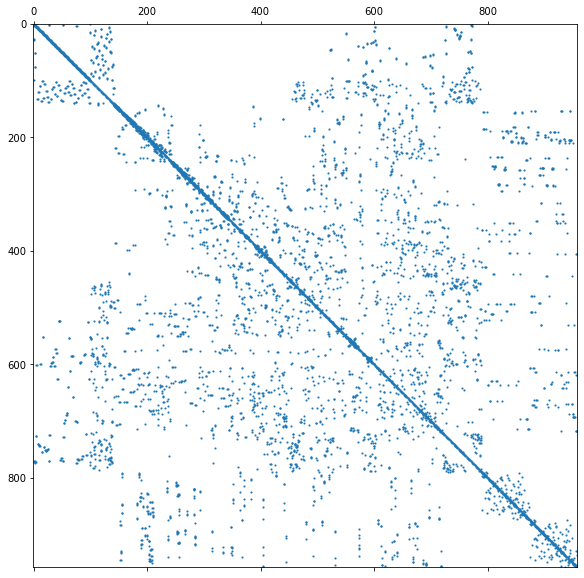

In [13]:
ax,fig = plt.subplots(figsize=(10,10))
plt.spy(S, markersize=1)

In [160]:
S[Npoints:, Npoints:]

array([[ 5.30147629e-01, -4.56615997e-01,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.56615997e-01,  5.63206964e-01,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  5.16552719e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.38207684e-01,  7.95443882e-31,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         7.95443882e-31,  2.32755654e-01, -3.40522682e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -3.40522682e-01,  4.98186382e-01]])

In [162]:
gamma_edges.shape[0]

336

In [332]:
# Matrix M_gamma (jump of gradient)

M_gamma = np.zeros((Ndof,Ndof))

for ied in range(gamma_edges.shape[0]):
    # table of dofs touched by the edge
    # 4 dofs: 2 points* 2 dof_per_point
    # col 0: idx, col1: ifa
    edge_dofs = np.zeros((4,2),dtype=int)
    # by construction, first face is internal  
    ifa_in = gamma_edges[ied,0]
    ifa_ex = gamma_edges[ied,1]  
    # dofs ifa_in
    edge_dofs[0,0] = glob_idx(ifa_in, 0)
    edge_dofs[1,0] = glob_idx(ifa_in, 1)
    edge_dofs[0:2,1] = ifa_in
    # dofs ifa_ex
    edge_dofs[2,0] = glob_idx(ifa_ex, 0)
    edge_dofs[3,0] = glob_idx(ifa_ex, 1)
    edge_dofs[2:4,1] = ifa_ex    
    print ("*******")    
    for idof1 in range(4):
        # get nodal values of reconstruction
        dof1 = edge_dofs[idof1,0] #global idx
        dof1_loc = idof1%2 #local idx
        ifa1 = edge_dofs[idof1,1] #idx of face
        GR1 = GR(ifa1) 
        sigma1 = sigma_in*int(ifa1==ifa_in) + sigma_ex*int(ifa1==ifa_ex)
        print ("sigma1", sigma1)
        tangent = coords[faces[ifa1,1],0:2]-coords[faces[ifa1,0],0:2]
        sign1 = int(ifa1==ifa_in)-int(ifa1==ifa_ex)
        normal = sign1*np.array([[0,1],[-1,0]])@tangent
        print ("normal", normal)
        #normal = normal/np.linalg.norm(normal)
        mean_sigma_grad_normal = 0.5*sigma1*np.dot(GR1[:,dof1_loc],normal)
        for idof2 in range(4):
            dof2 = edge_dofs[idof2,0] #global idx
            dof2_loc = idof2%2 #local idx
            ifa2 = edge_dofs[idof2,1]
            R2 = recpot(ifa2) 
            ## Setting node prec as first vertex and node post as second
            ## should be indifferent though
            node_per_face_2 = np.count_nonzero(faces[ifa2,:] != -1)
            if (node_per_face_2 ==4):
                v2A = R2[0,dof2_loc]
                v2B = R2[1,dof2_loc]
            else:
                v2A = R2[1,dof2_loc]
                v2B = R2[0,dof2_loc]
            # sign (jump must be ex-in)
            sign2 = int(ifa2==ifa_ex)-int(ifa2==ifa_in)
            # contribution
            ## edge length
            mod_E = np.linalg.norm(coords[faces[ifa2,0],:]-coords[faces[ifa2,1],:])
            ## integral
            jump_of_rec = 0.5*(v2A+v2B)*sign2
            M_gamma[dof1,dof2] = M_gamma[dof1,dof2] + mean_sigma_grad_normal*jump_of_rec
#            print ("v2A, v2B: ", v2A,v2B)
#            print ("sign2", sign2)
#            print ("sigma1", sigma1)
#            print ("mod_E", mod_E)
#            print ("jump_of_rec", jump_of_rec)
#            print ("mean_sigma_grad_normal", mean_sigma_grad_normal)
#            print ("GR1", GR1)
#            print ("tangent", tangent)
#            print ("normal", normal)
#            print ("mean_sigma_grad_normal", mean_sigma_grad_normal)
#            print ("jump_of_rec", jump_of_rec)

*******
sigma1 0.1
normal [ 0.0037201  -0.01117741]
sigma1 0.1
normal [ 0.0037201  -0.01117741]
sigma1 1.0
normal [ 0.0037201  -0.01117741]
sigma1 1.0
normal [ 0.0037201  -0.01117741]
*******
sigma1 0.1
normal [-0.02238917  0.02254658]
sigma1 0.1
normal [-0.02238917  0.02254658]
sigma1 1.0
normal [-0.02238917  0.02254658]
sigma1 1.0
normal [-0.02238917  0.02254658]
*******
sigma1 0.1
normal [-0.01225185  0.01018297]
sigma1 0.1
normal [-0.01225185  0.01018297]
sigma1 1.0
normal [-0.01225185  0.01018297]
sigma1 1.0
normal [-0.01225185  0.01018297]
*******
sigma1 0.1
normal [ 0.00123131 -0.01506546]
sigma1 0.1
normal [ 0.00123131 -0.01506546]
sigma1 1.0
normal [ 0.00123131 -0.01506546]
sigma1 1.0
normal [ 0.00123131 -0.01506546]
*******
sigma1 0.1
normal [ 0.00350829 -0.02219813]
sigma1 0.1
normal [ 0.00350829 -0.02219813]
sigma1 1.0
normal [ 0.00350829 -0.02219813]
sigma1 1.0
normal [ 0.00350829 -0.02219813]
*******
sigma1 0.1
normal [-0.01764957  0.01255343]
sigma1 0.1
normal [-0.017649

sigma1 1.0
normal [0.02212942 0.00232448]
sigma1 1.0
normal [0.02212942 0.00232448]
*******
sigma1 0.1
normal [ 0.02998245 -0.02003335]
sigma1 0.1
normal [ 0.02998245 -0.02003335]
sigma1 1.0
normal [ 0.02998245 -0.02003335]
sigma1 1.0
normal [ 0.02998245 -0.02003335]
*******
sigma1 0.1
normal [-0.00232582  0.02993816]
sigma1 0.1
normal [-0.00232582  0.02993816]
sigma1 1.0
normal [-0.00232582  0.02993816]
sigma1 1.0
normal [-0.00232582  0.02993816]
*******
sigma1 0.1
normal [0.01225185 0.01018299]
sigma1 0.1
normal [0.01225185 0.01018299]
sigma1 1.0
normal [0.01225185 0.01018299]
sigma1 1.0
normal [0.01225185 0.01018299]
*******
sigma1 0.1
normal [-0.01730196 -0.00076   ]
sigma1 0.1
normal [-0.01730196 -0.00076   ]
sigma1 1.0
normal [-0.01730196 -0.00076   ]
sigma1 1.0
normal [-0.01730196 -0.00076   ]
*******
sigma1 0.1
normal [0.01733895 0.00044125]
sigma1 0.1
normal [0.01733895 0.00044125]
sigma1 1.0
normal [0.01733895 0.00044125]
sigma1 1.0
normal [0.01733895 0.00044125]
*******
sigm

sigma1 0.1
normal [ 0.02237399 -0.0206781 ]
sigma1 1.0
normal [ 0.02237399 -0.0206781 ]
sigma1 1.0
normal [ 0.02237399 -0.0206781 ]
*******
sigma1 0.1
normal [-0.02113705 -0.00375502]
sigma1 0.1
normal [-0.02113705 -0.00375502]
sigma1 1.0
normal [-0.02113705 -0.00375502]
sigma1 1.0
normal [-0.02113705 -0.00375502]
*******
sigma1 0.1
normal [-0.00673341 -0.00245187]
sigma1 0.1
normal [-0.00673341 -0.00245187]
sigma1 1.0
normal [-0.00673341 -0.00245187]
sigma1 1.0
normal [-0.00673341 -0.00245187]
*******
sigma1 0.1
normal [0.00553362 0.0230047 ]
sigma1 0.1
normal [0.00553362 0.0230047 ]
sigma1 1.0
normal [0.00553362 0.0230047 ]
sigma1 1.0
normal [0.00553362 0.0230047 ]
*******
sigma1 0.1
normal [-0.02998244 -0.02003334]
sigma1 0.1
normal [-0.02998244 -0.02003334]
sigma1 1.0
normal [-0.02998244 -0.02003334]
sigma1 1.0
normal [-0.02998244 -0.02003334]
*******
sigma1 0.1
normal [-0.00233275 -0.00130948]
sigma1 0.1
normal [-0.00233275 -0.00130948]
sigma1 1.0
normal [-0.00233275 -0.00130948]


sigma1 0.1
normal [0.02831919 0.00829444]
sigma1 1.0
normal [0.02831919 0.00829444]
sigma1 1.0
normal [0.02831919 0.00829444]
*******
sigma1 0.1
normal [ 0.00781987 -0.01922207]
sigma1 0.1
normal [ 0.00781987 -0.01922207]
sigma1 1.0
normal [ 0.00781987 -0.01922207]
sigma1 1.0
normal [ 0.00781987 -0.01922207]
*******
sigma1 0.1
normal [0.02238917 0.02254657]
sigma1 0.1
normal [0.02238917 0.02254657]
sigma1 1.0
normal [0.02238917 0.02254657]
sigma1 1.0
normal [0.02238917 0.02254657]
*******
sigma1 0.1
normal [ 0.02790771 -0.00792906]
sigma1 0.1
normal [ 0.02790771 -0.00792906]
sigma1 1.0
normal [ 0.02790771 -0.00792906]
sigma1 1.0
normal [ 0.02790771 -0.00792906]
*******
sigma1 0.1
normal [0.00207483 0.01260255]
sigma1 0.1
normal [0.00207483 0.01260255]
sigma1 1.0
normal [0.00207483 0.01260255]
sigma1 1.0
normal [0.00207483 0.01260255]
*******
sigma1 0.1
normal [-0.01591159  0.02239172]
sigma1 0.1
normal [-0.01591159  0.02239172]
sigma1 1.0
normal [-0.01591159  0.02239172]
sigma1 1.0
nor

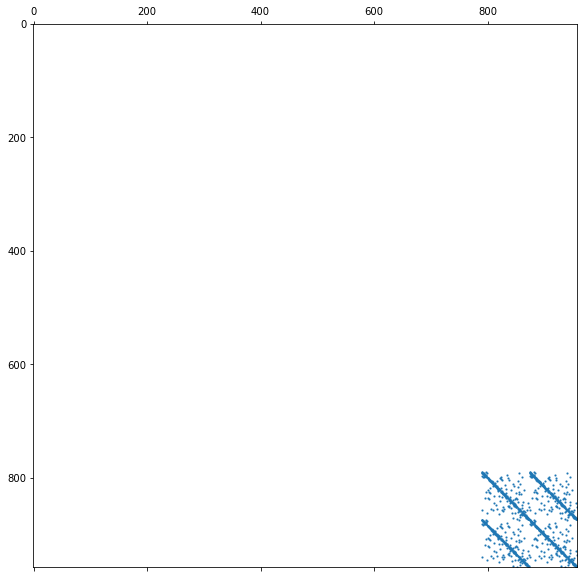

In [214]:
ax,fig = plt.subplots(figsize=(10,10))
plt.spy(M_gamma, markersize=1)

In [169]:
# calculate the integral over the [0,1] of the product between 2 affine functions assigned through their 
# values at vertices 0 and 1 (first values at 0 of f1 and f2 an then values at 1)
def calc_r2_prod_integ(v1A,v1B,v2A,v2B): 
    return v1A*v2A*1/3 + (v1A*v2B+v1B*v2A)*1/6 + v1B*v2B*1/3

In [328]:
# matrix N_gamma (jump penalisation)

N_gamma = np.zeros((Ndof,Ndof))
for ied in range(gamma_edges.shape[0]):
    print ("***********")
    print ("Edge: ", ied)
    # table of dofs touched by the edge
    # 4 dofs: 2 points* 2 dof_per_point
    # col 0: idx, col1: ifa
    edge_dofs = np.zeros((4,2),dtype=int)
    ifa_in = gamma_edges[ied,0]
    ifa_ex = gamma_edges[ied,1]  
    # dofs ifa_in
    edge_dofs[0,0] = glob_idx(ifa_in, 0)
    edge_dofs[1,0] = glob_idx(ifa_in, 1)
    edge_dofs[0:2,1] = ifa_in
    # dofs ifa_ex
    edge_dofs[2,0] = glob_idx(ifa_ex, 0)
    edge_dofs[3,0] = glob_idx(ifa_ex, 1)
    edge_dofs[2:4,1] = ifa_ex
    for idof1 in range(4):
        # get nodal values of reconstruction
        dof1 = edge_dofs[idof1,0] #global idx
        dof1_loc = idof1%2 #local idx
        ifa1 = edge_dofs[idof1,1]
        R1 = recpot(ifa1)
        ## convention: node1 is prec, node2 is post: 
        ## to distinguish must understand what face I'm on, 
        ## the 4-verticed one or the the 3-verticed one 
        node_per_face_1 = np.count_nonzero(faces[ifa1,:] != -1)
        if (node_per_face_1 ==4):
            v1A = R1[0,dof1_loc]
            v1B = R1[1,dof1_loc]
        else:
            v1A = R1[1,dof1_loc]
            v1B = R1[0,dof1_loc]
        # sign (jump must be ex-in)
        sign1 = int(ifa1==ifa_ex)-int(ifa1==ifa_in)
        for idof2 in range(4):
            dof2 = edge_dofs[idof2,0] #global idx
            dof2_loc = idof2%2 #local idx
            ifa2 = edge_dofs[idof2,1]
            R2 = recpot(ifa2) 
            # ATTENTION: important detail
            # the order of intface nodes for genrated elements is pos//prec for the one
            # with 3 vertices and prec//pos for the one with 4 vertices (mind the inversion)
            node_per_face_2 = np.count_nonzero(faces[ifa2,:] != -1)
            if (node_per_face_2 ==4):
                v2A = R2[0,dof2_loc]
                v2B = R2[1,dof2_loc]
            else:
                v2A = R2[1,dof2_loc]
                v2B = R2[0,dof2_loc]
            # sign (jump must be ex-in)
            sign2 = int(ifa2==ifa_ex)-int(ifa2==ifa_in)
            # contribution
            ## edge length
            mod_E = np.linalg.norm(coords[faces[ifa2,0],:]-coords[faces[ifa2,1],:])
            ## integral
            local_contrib = calc_r2_prod_integ(v1A,v1B,v2A,v2B) 
#            print ("******")
            print ("mod_E", mod_E)
#            print ("sign1", sign1)
#            print ("local_contrib", local_contrib)
#            print ("******")
            N_gamma[dof1,dof2] = N_gamma[dof1,dof2] + mod_E*sign1*sign2*local_contrib

***********
Edge:  0
mod_E 0.01178022442497606
mod_E 0.01178022442497606
mod_E 0.01178022442497606
mod_E 0.01178022442497606
mod_E 0.01178022442497606
mod_E 0.01178022442497606
mod_E 0.01178022442497606
mod_E 0.01178022442497606
mod_E 0.01178022442497606
mod_E 0.01178022442497606
mod_E 0.01178022442497606
mod_E 0.01178022442497606
mod_E 0.01178022442497606
mod_E 0.01178022442497606
mod_E 0.01178022442497606
mod_E 0.01178022442497606
***********
Edge:  1
mod_E 0.031774565080641845
mod_E 0.031774565080641845
mod_E 0.031774565080641845
mod_E 0.031774565080641845
mod_E 0.031774565080641845
mod_E 0.031774565080641845
mod_E 0.031774565080641845
mod_E 0.031774565080641845
mod_E 0.031774565080641845
mod_E 0.031774565080641845
mod_E 0.031774565080641845
mod_E 0.031774565080641845
mod_E 0.031774565080641845
mod_E 0.031774565080641845
mod_E 0.031774565080641845
mod_E 0.031774565080641845
***********
Edge:  2
mod_E 0.015931124719570006
mod_E 0.015931124719570006
mod_E 0.015931124719570006
mod_E 0.

mod_E 0.023995382214455515
mod_E 0.023995382214455515
mod_E 0.023995382214455515
mod_E 0.023995382214455515
mod_E 0.023995382214455515
mod_E 0.023995382214455515
mod_E 0.023995382214455515
mod_E 0.023995382214455515
mod_E 0.023995382214455515
mod_E 0.023995382214455515
mod_E 0.023995382214455515
mod_E 0.023995382214455515
mod_E 0.023995382214455515
mod_E 0.023995382214455515
***********
Edge:  20
mod_E 0.01178021862003248
mod_E 0.01178021862003248
mod_E 0.01178021862003248
mod_E 0.01178021862003248
mod_E 0.01178021862003248
mod_E 0.01178021862003248
mod_E 0.01178021862003248
mod_E 0.01178021862003248
mod_E 0.01178021862003248
mod_E 0.01178021862003248
mod_E 0.01178021862003248
mod_E 0.01178021862003248
mod_E 0.01178021862003248
mod_E 0.01178021862003248
mod_E 0.01178021862003248
mod_E 0.01178021862003248
***********
Edge:  21
mod_E 0.021467759106305162
mod_E 0.021467759106305162
mod_E 0.021467759106305162
mod_E 0.021467759106305162
mod_E 0.021467759106305162
mod_E 0.021467759106305162


mod_E 0.02100747367854155
mod_E 0.02100747367854155
mod_E 0.02100747367854155
***********
Edge:  39
mod_E 0.007165913597740387
mod_E 0.007165913597740387
mod_E 0.007165913597740387
mod_E 0.007165913597740387
mod_E 0.007165913597740387
mod_E 0.007165913597740387
mod_E 0.007165913597740387
mod_E 0.007165913597740387
mod_E 0.007165913597740387
mod_E 0.007165913597740387
mod_E 0.007165913597740387
mod_E 0.007165913597740387
mod_E 0.007165913597740387
mod_E 0.007165913597740387
mod_E 0.007165913597740387
mod_E 0.007165913597740387
***********
Edge:  40
mod_E 0.02165861612083285
mod_E 0.02165861612083285
mod_E 0.02165861612083285
mod_E 0.02165861612083285
mod_E 0.02165861612083285
mod_E 0.02165861612083285
mod_E 0.02165861612083285
mod_E 0.02165861612083285
mod_E 0.02165861612083285
mod_E 0.02165861612083285
mod_E 0.02165861612083285
mod_E 0.02165861612083285
mod_E 0.02165861612083285
mod_E 0.02165861612083285
mod_E 0.02165861612083285
mod_E 0.02165861612083285
***********
Edge:  41
mod_E 0.

mod_E 0.020751831955721316
mod_E 0.020751831955721316
mod_E 0.020751831955721316
mod_E 0.020751831955721316
mod_E 0.020751831955721316
mod_E 0.020751831955721316
***********
Edge:  59
mod_E 0.03177455943213271
mod_E 0.03177455943213271
mod_E 0.03177455943213271
mod_E 0.03177455943213271
mod_E 0.03177455943213271
mod_E 0.03177455943213271
mod_E 0.03177455943213271
mod_E 0.03177455943213271
mod_E 0.03177455943213271
mod_E 0.03177455943213271
mod_E 0.03177455943213271
mod_E 0.03177455943213271
mod_E 0.03177455943213271
mod_E 0.03177455943213271
mod_E 0.03177455943213271
mod_E 0.03177455943213271
***********
Edge:  60
mod_E 0.02901224025289439
mod_E 0.02901224025289439
mod_E 0.02901224025289439
mod_E 0.02901224025289439
mod_E 0.02901224025289439
mod_E 0.02901224025289439
mod_E 0.02901224025289439
mod_E 0.02901224025289439
mod_E 0.02901224025289439
mod_E 0.02901224025289439
mod_E 0.02901224025289439
mod_E 0.02901224025289439
mod_E 0.02901224025289439
mod_E 0.02901224025289439
mod_E 0.029012

mod_E 0.02315693836826763
mod_E 0.02315693836826763
mod_E 0.02315693836826763
mod_E 0.02315693836826763
mod_E 0.02315693836826763
mod_E 0.02315693836826763
mod_E 0.02315693836826763
mod_E 0.02315693836826763
mod_E 0.02315693836826763
mod_E 0.02315693836826763
mod_E 0.02315693836826763
mod_E 0.02315693836826763
mod_E 0.02315693836826763
mod_E 0.02315693836826763
mod_E 0.02315693836826763
mod_E 0.02315693836826763
***********
Edge:  79
mod_E 0.00834206945140988
mod_E 0.00834206945140988
mod_E 0.00834206945140988
mod_E 0.00834206945140988
mod_E 0.00834206945140988
mod_E 0.00834206945140988
mod_E 0.00834206945140988
mod_E 0.00834206945140988
mod_E 0.00834206945140988
mod_E 0.00834206945140988
mod_E 0.00834206945140988
mod_E 0.00834206945140988
mod_E 0.00834206945140988
mod_E 0.00834206945140988
mod_E 0.00834206945140988
mod_E 0.00834206945140988
***********
Edge:  80
mod_E 0.008342064099978097
mod_E 0.008342064099978097
mod_E 0.008342064099978097
mod_E 0.008342064099978097
mod_E 0.00834206

mod_E 0.02366088159463384
mod_E 0.02366088159463384
mod_E 0.02366088159463384
mod_E 0.02366088159463384
mod_E 0.02366088159463384
mod_E 0.02366088159463384
***********
Edge:  98
mod_E 0.03605941638185222
mod_E 0.03605941638185222
mod_E 0.03605941638185222
mod_E 0.03605941638185222
mod_E 0.03605941638185222
mod_E 0.03605941638185222
mod_E 0.03605941638185222
mod_E 0.03605941638185222
mod_E 0.03605941638185222
mod_E 0.03605941638185222
mod_E 0.03605941638185222
mod_E 0.03605941638185222
mod_E 0.03605941638185222
mod_E 0.03605941638185222
mod_E 0.03605941638185222
mod_E 0.03605941638185222
***********
Edge:  99
mod_E 0.002675152485696635
mod_E 0.002675152485696635
mod_E 0.002675152485696635
mod_E 0.002675152485696635
mod_E 0.002675152485696635
mod_E 0.002675152485696635
mod_E 0.002675152485696635
mod_E 0.002675152485696635
mod_E 0.002675152485696635
mod_E 0.002675152485696635
mod_E 0.002675152485696635
mod_E 0.002675152485696635
mod_E 0.002675152485696635
mod_E 0.002675152485696635
mod_E 

mod_E 0.015115697436868228
mod_E 0.015115697436868228
***********
Edge:  117
mod_E 0.01731865812449278
mod_E 0.01731865812449278
mod_E 0.01731865812449278
mod_E 0.01731865812449278
mod_E 0.01731865812449278
mod_E 0.01731865812449278
mod_E 0.01731865812449278
mod_E 0.01731865812449278
mod_E 0.01731865812449278
mod_E 0.01731865812449278
mod_E 0.01731865812449278
mod_E 0.01731865812449278
mod_E 0.01731865812449278
mod_E 0.01731865812449278
mod_E 0.01731865812449278
mod_E 0.01731865812449278
***********
Edge:  118
mod_E 0.029508899173641193
mod_E 0.029508899173641193
mod_E 0.029508899173641193
mod_E 0.029508899173641193
mod_E 0.029508899173641193
mod_E 0.029508899173641193
mod_E 0.029508899173641193
mod_E 0.029508899173641193
mod_E 0.029508899173641193
mod_E 0.029508899173641193
mod_E 0.029508899173641193
mod_E 0.029508899173641193
mod_E 0.029508899173641193
mod_E 0.029508899173641193
mod_E 0.029508899173641193
mod_E 0.029508899173641193
***********
Edge:  119
mod_E 0.008719021920110735
mo

mod_E 0.01734456084172827
mod_E 0.01734456084172827
mod_E 0.01734456084172827
mod_E 0.01734456084172827
mod_E 0.01734456084172827
mod_E 0.01734456084172827
mod_E 0.01734456084172827
mod_E 0.01734456084172827
mod_E 0.01734456084172827
mod_E 0.01734456084172827
mod_E 0.01734456084172827
***********
Edge:  136
mod_E 0.016708917209746602
mod_E 0.016708917209746602
mod_E 0.016708917209746602
mod_E 0.016708917209746602
mod_E 0.016708917209746602
mod_E 0.016708917209746602
mod_E 0.016708917209746602
mod_E 0.016708917209746602
mod_E 0.016708917209746602
mod_E 0.016708917209746602
mod_E 0.016708917209746602
mod_E 0.016708917209746602
mod_E 0.016708917209746602
mod_E 0.016708917209746602
mod_E 0.016708917209746602
mod_E 0.016708917209746602
***********
Edge:  137
mod_E 0.01411640143101218
mod_E 0.01411640143101218
mod_E 0.01411640143101218
mod_E 0.01411640143101218
mod_E 0.01411640143101218
mod_E 0.01411640143101218
mod_E 0.01411640143101218
mod_E 0.01411640143101218
mod_E 0.01411640143101218
mo

mod_E 0.02564543504353117
mod_E 0.02564543504353117
mod_E 0.02564543504353117
mod_E 0.02564543504353117
mod_E 0.02564543504353117
mod_E 0.02564543504353117
mod_E 0.02564543504353117
mod_E 0.02564543504353117
***********
Edge:  155
mod_E 0.01270469249902084
mod_E 0.01270469249902084
mod_E 0.01270469249902084
mod_E 0.01270469249902084
mod_E 0.01270469249902084
mod_E 0.01270469249902084
mod_E 0.01270469249902084
mod_E 0.01270469249902084
mod_E 0.01270469249902084
mod_E 0.01270469249902084
mod_E 0.01270469249902084
mod_E 0.01270469249902084
mod_E 0.01270469249902084
mod_E 0.01270469249902084
mod_E 0.01270469249902084
mod_E 0.01270469249902084
***********
Edge:  156
mod_E 0.012122261618532757
mod_E 0.012122261618532757
mod_E 0.012122261618532757
mod_E 0.012122261618532757
mod_E 0.012122261618532757
mod_E 0.012122261618532757
mod_E 0.012122261618532757
mod_E 0.012122261618532757
mod_E 0.012122261618532757
mod_E 0.012122261618532757
mod_E 0.012122261618532757
mod_E 0.012122261618532757
mod_E 

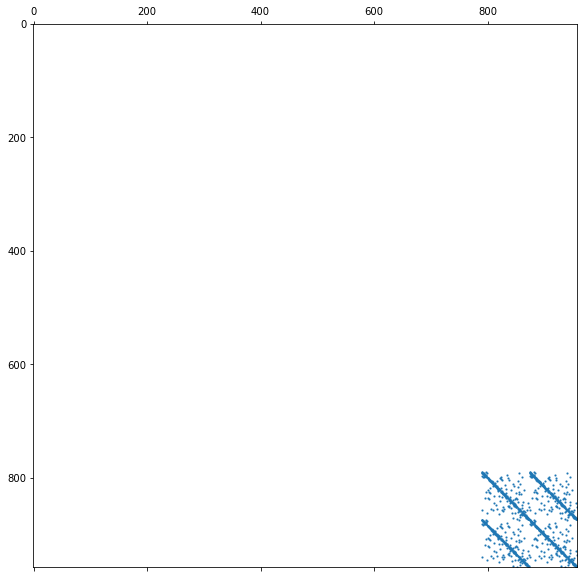

In [277]:
ax,fig = plt.subplots(figsize=(10,10))
plt.spy(N_gamma, markersize=1)

In [329]:
# l.h.s: b_phi (jump penalisation)

# initialize jump datum phi on interface nodes (constant value)
Npoints_intface = Npoints-Npoints_init
phi_datum = np.zeros((Npoints_intface))
for ino in range(Npoints_intface):
    xx = coords[Npoints_init+ino,0]
    yy = coords[Npoints_init+ino,1]
    phi_datum[ino]= 1.0

b_phi = np.zeros((Ndof))
for ied in range(gamma_edges.shape[0]):
    # table of dofs touched by the edge
    # 4 dofs: 2 points* 2 dof_per_point
    # col 0: idx, col1: ifa
    edge_dofs = np.zeros((4,2),dtype=int)
    ifa_in = gamma_edges[ied,0]
    ifa_ex = gamma_edges[ied,1]  
    # dofs ifa_in
    edge_dofs[0,0] = glob_idx(ifa_in, 0)
    edge_dofs[1,0] = glob_idx(ifa_in, 1)
    edge_dofs[0:2,1] = ifa_in
    # dofs ifa_ex
    edge_dofs[2,0] = glob_idx(ifa_ex, 0)
    edge_dofs[3,0] = glob_idx(ifa_ex, 1)
    edge_dofs[2:4,1] = ifa_ex    
    for idof in range(4):
        # get nodal values of reconstruction
        dof = edge_dofs[idof,0] #global idx
        dof_loc = idof%2 #local idx
        ifa = edge_dofs[idof,1]
        R = recpot(ifa)
        # vertex 1 = node prec
        node_per_face = np.count_nonzero(faces[ifa,:] != -1)
        if (node_per_face ==4):
            v1A = R[0,dof_loc]
            v2B = R[1,dof_loc]
        else:
            v1A = R[1,dof_loc]
            v1B = R[0,dof_loc]        
        v1A = R[0,dof_loc]
        v1B = R[1,dof_loc]
        # get nodal values of phi_datum
        # vertex 1 = node prec
        if (node_per_face_2 ==4):        
            ino1 = faces[ifa,0]
            ino2 = faces[ifa,1]
        else:
            ino1 = faces[ifa,1]
            ino2 = faces[ifa,0]                
        ## attention: indexes are shifted
        v2A = phi_datum[ino1-Npoints_init]
        v2B = phi_datum[ino2-Npoints_init]
        ## edge length
        mod_E = np.linalg.norm(coords[faces[ifa,0],:]-coords[faces[ifa,1],:])
        # sign (jump must be ex-in)
        sign = int(ifa==ifa_ex)-int(ifa==ifa_in)
        # local contribution
        local_contrib = calc_r2_prod_integ(v1A,v1B,v2A,v2B) 
        # integral 
        b_phi[dof] = b_phi[dof] + mod_E*sign*local_contrib

In [293]:
# TEST WITH AFFINE SOLUTION 
# MODE 1: iterative method

# user-defined parameter (must respect the inf-sup condition, big enough)
# NOTICE: it must be big enough, but too big impacts on convergence of iterative solver)
eta = 1e6

def ref_u(x,y):
    return y
def make_product(u):
    return np.dot (G+S-M_gamma,u)
#impose BCs on 
def impose_bc(u):
    for ino in range(Npoints_init):
        if (bnd_mask[ino]>0):
            x = coords[ino,0]
            y = coords[ino,1]
            u[ino] = ref_u(x,y)
    return u
# set 0 at border
def impose_zero_at_border(u):
    eps = 1e-6
    mask = (bnd_mask>0)
    for ino in range(Npoints_init):
        if (mask[ino]):
            x = coords[ino,0]
            y = coords[ino,1]
            u[ino] = 0
    return u

# initial guess: u = 0
b = np.zeros((Ndof))
u = np.zeros((Ndof)) 
impose_bc(u)
impose_bc(b)
r = b - make_product(u)
impose_zero_at_border(r)
p = r
rho_0 = np.dot(r,r)
theta = np.dot(p, make_product(p))


it = 0
maxiter = 2000
while (rho_0 > 1e-12 and it<maxiter):
    alpha = rho_0/theta
    u = u + alpha*p 
    impose_bc(u)
    r = r - alpha*make_product(p)
    impose_zero_at_border(r)
    rho_1 = np.dot(r,r)
    beta = rho_1/rho_0
    p = r + beta*p
    impose_zero_at_border(p)
    theta = np.dot(p, make_product(p))
    rho_0 = rho_1
    it = it + 1

print ("Statistics")
print ("iterations: ",it," residual: ", np.linalg.norm(r))

Statistics
iterations:  2000  residual:  1.4247075311250288


In [330]:
# SOLVE SYSTEM BY DIRECT METHOD: homogenous dirichlet and constant jump 

# stability parameter:
eta = 0.1
# 1: define u_g s.t. u_g|_bnd=g
b = np.zeros((Ndof))
#b = eta*b_phi
impose_bc(b)
#impose_zero_at_border(b)
# 2: impose bnd cnd on matrix
A_0 = G+S+eta*N_gamma-M_gamma
for ino in range(Npoints_init):
    if (bnd_mask[ino]>0):
        A_0[ino,:] = 0
        A_0[ino,ino] = 1
# 2: solve
u = np.linalg.solve(A_0, b)

In [331]:
# Visualization 

def plot3D (elevation,azimuth):
    fig = plt.figure(figsize = (15,15))
    ax  = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elevation, azim=azimuth)
    for ifa in range(Nfaces):
        if (cut_faces[ifa]!=1):
            node_per_face = np.count_nonzero(faces[ifa,:] != -1)
            u_F = np.zeros(node_per_face)
            xx  = np.zeros(node_per_face)
            yy  = np.zeros(node_per_face)
            for ino in range(node_per_face):
                xx[ino], yy[ino] = coords[faces[ifa][ino],0:2]
                ino_glob = glob_idx(ifa,ino)
                u_F [ino] = u [ino_glob]
         #   print (xx,yy,u_F)
            surf = ax.plot_trisurf(xx, yy, u_F, cmap=cm.coolwarm)
    plt.show()

interact(plot3D, elevation=(-90, 90, 5), azimuth=(-180, 180, 5))

interactive(children=(IntSlider(value=0, description='elevation', max=90, min=-90, step=5), IntSlider(value=0,…

<function __main__.plot3D(elevation, azimuth)>

In [304]:
# test subset of matrices (DIRECT METHOD)

# stability parameter:
eta = 1e7
# 1: define u_g s.t. u_g|_bnd=g
u_g = np.zeros((Ndof))
impose_bc(u_g)
# 2: impose bnd cnd on matrix
A_0 = G+S+eta*N_gamma
for ino in range(Npoints_init):
    if (bnd_mask[ino]>0):
        A_0[ino,:] = 0
        A_0[ino,ino] = 1
# 2: solve
u = np.linalg.solve(A_0, u_g)


In [305]:
# Visualization 

def plot3D (elevation,azimuth):
    fig = plt.figure(figsize = (15,15))
    ax  = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elevation, azim=azimuth)
    for ifa in range(Nfaces):
        if (cut_faces[ifa]!=1):
            node_per_face = np.count_nonzero(faces[ifa,:] != -1)
            u_F = np.zeros(node_per_face)
            xx  = np.zeros(node_per_face)
            yy  = np.zeros(node_per_face)
            for ino in range(node_per_face):
                xx[ino], yy[ino] = coords[faces[ifa][ino],0:2]
                ino_glob = glob_idx(ifa,ino)
                u_F [ino] = u [ino_glob]
         #   print (xx,yy,u_F)
            surf = ax.plot_trisurf(xx, yy, u_F, cmap=cm.coolwarm)
    plt.show()

interact(plot3D, elevation=(-90, 90, 5), azimuth=(-180, 180, 5))

interactive(children=(IntSlider(value=0, description='elevation', max=90, min=-90, step=5), IntSlider(value=0,…

<function __main__.plot3D(elevation, azimuth)>

In [227]:
print ("NORMS:")
print ("G", np.linalg.norm(G))
print ("S", np.linalg.norm(G))
print ("M_gamma", np.linalg.norm(M_gamma))
print ("eta*N_gamma", eta*np.linalg.norm(N_gamma))

NORMS:
G 107.51227935334634
S 107.51227935334634
M_gamma 23.775826921518206
eta*N_gamma 4549596.226132222
